# HI Multi-Model Traffic Flow Prediction: STGCN vs RNN vs GAT

This notebook implements and compares three different deep learning approaches for traffic flow prediction on multiple datasets:

1. **STGCN** - Spatio-Temporal Graph Convolutional Network
2. **RNN** - Recurrent Neural Network (LSTM)  
3. **GAT** - Graph Attention Network

Each model captures different aspects of traffic patterns and we'll compare their performance comprehensively.

## 📊 Supported Datasets

This notebook supports **three datasets** - switch between them using the `DATASET_NAME` variable in Step 2:

1. **PEMS08**: California highway traffic sensors
   - 170 sensors
   - 5-minute intervals, ~17,000 timesteps
   - Features: Flow, Occupancy, Speed (mph → km/h)

2. **HZMetro**: Hangzhou Metro system
   - Pre-split train/val/test data
   - Multiple graph types (connectivity, correlation, similarity)
   - Features from metro operations

3. **SHMetro**: Shanghai Metro system
   - Pre-split train/val/test data  
   - Multiple graph types (connectivity, correlation, similarity)
   - Features from metro operations

## Task
- **Input**: Past 12 timesteps (1 hour)
- **Output**: Next 3 timesteps (15 minutes)  
- **Features**: Multi-feature traffic/metro data (typically 3 features)

## Model Comparison
- **STGCN**: Combines Chebyshev graph convolution + 2D convolution
- **RNN**: LSTM for temporal modeling (ignores spatial relationships)
- **GAT**: Graph attention + 2D convolution for adaptive spatial modeling
- **Input**: (batch_size, 170, 12, 3) - 170 sensors, 12 timesteps, 3 features
- **Output**: (batch_size, 170, 3, 3) - 170 sensors, 3 future timesteps, 3 features

---

## 📋 **Notebook Structure Overview**

This notebook is organized into clear steps:

1. **Step 1**: Environment Setup and Dependencies
2. **Step 2**: Data Loading and Preprocessing  
3. **Step 3**: Model Architecture Implementation
4. **Step 4**: Multi-Model Training Framework
5. **Step 5**: Comprehensive Model Evaluation and Comparison
6. **Step 6**: Extensions and Future Improvements

Each step builds upon the previous one, creating a complete pipeline for traffic flow prediction and model comparison.


# 🚀 Step 1: Environment Setup and Dependencies

In this step, we'll:
- Install required packages for PyTorch, PyTorch Geometric, and other dependencies
- Import necessary libraries for deep learning, data processing, and visualization
- Set up the computing environment (CPU/GPU)
- Configure random seeds for reproducibility

## What we're installing:
- **PyTorch**: Deep learning framework
- **PyTorch Geometric**: Graph neural network library
- **Scikit-learn**: Data preprocessing and metrics
- **Matplotlib & Seaborn**: Visualization libraries

## Key Setup Details:
- **Device**: Automatically detects and uses GPU if available
- **Random Seeds**: Ensures reproducible results
- **Style**: Sets up consistent plotting aesthetics


In [3]:
# Install required packages (run this cell first in Google Colab/Kaggle)
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
%pip install torch-geometric
%pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
%pip install scikit-learn matplotlib seaborn

# Verify installation
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
PyTorch version: 2.6.0+cu118
CUDA available: True
CUDA device: Tesla T4
CUDA memory: 15.8 GB


In [119]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch_geometric
from torch_geometric.nn import ChebConv, GATConv
from torch_geometric.utils import dense_to_sparse

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set matplotlib style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


Using device: cuda


# 📊 Step 2: Data Loading and Preprocessing

In this step, we'll:
- **Select Dataset**: Choose from PEMS08, HZMetro, or SHMetro
- Load dataset with unified loader (handles .npz, .pkl, .csv formats)
- Handle different data formats and nested file structures
- Preprocess the data with proper normalization strategies
- Create training sequences for time series prediction
- Split data into train/validation/test sets (or use pre-split data)
- Convert adjacency matrix to PyTorch Geometric format

## Dataset Selection:
**Change the `DATASET_NAME` variable in the cell below to switch datasets:**
- `'PEMS08'` - California highway sensors (requires splitting)
- `'HZMetro'` - Hangzhou Metro (pre-split, uses `graph_hz_conn.pkl` by default)
- `'SHMetro'` - Shanghai Metro (pre-split, uses `graph_sh_conn.pkl` by default)

**For Metro datasets**, you can also change `graph_type`:
- `'conn'` - Connectivity graph (default)
- `'cor'` - Correlation graph
- `'sml'` - Similarity graph

## Data Processing Pipeline:
1. **Load Data**: Automatic format detection (.npz for PEMS08, .pkl for Metro)
2. **Convert Units**: Speed from mph to km/h (PEMS08 only)
3. **Normalize**: Per-sensor, per-feature normalization
4. **Create Sequences**: 12 timesteps → 3 timesteps prediction
5. **Split Data**: 70% train, 15% validation, 15% test (PEMS08) or use pre-split (Metro)
6. **Graph Format**: Convert to edge_index and edge_weight (PyG format)

## Key Features:
- **Unified Loader**: Handles multiple dataset formats automatically
- **Robust Loading**: Handles nested .npz, pickle files, various graph formats
- **Multi-feature**: Flow, occupancy, speed (3 features typically)
- **Flexible Normalization**: Multiple strategies available
- **Graph Structure**: Proper PyG format for GNNs


In [134]:
# ============================================================================
# UNIFIED DATA LOADER - Supports PEMS08, HZMetro, and SHMetro Datasets
# ============================================================================

import pickle
import os
from pathlib import Path

def find_dataset_dir(dataset_name):
    """
    Recursively search for a dataset directory
    Returns the full path if found, None otherwise
    """
    possible_names = [dataset_name, dataset_name.upper(), dataset_name.lower()]
    
    # Common base directories to search
    search_dirs = ['.', 'graph-dataset', 'Dataset', '../input/Dataset', '../input', 'input']
    
    for search_dir in search_dirs:
        if not os.path.exists(search_dir):
            continue
        
        # Search recursively
        for root, dirs, files in os.walk(search_dir):
            for dir_name in dirs:
                # Case-insensitive matching
                for possible_name in possible_names:
                    if dir_name.lower() == possible_name.lower():
                        full_path = os.path.join(root, dir_name)
                        return full_path
    
    return None


def load_metro_data(dataset_name, graph_type='conn'):
    """
    Load Metro dataset (HZMetro or SHMetro) from pickle files
    Automatically searches for the dataset directory
    
    Args:
        dataset_name: Name of the dataset ('HZMetro' or 'SHMetro')
        graph_type: Type of graph to use ('conn', 'cor', or 'sml')
                    - 'conn': Connectivity graph
                    - 'cor': Correlation graph  
                    - 'sml': Similarity graph
    
    Returns:
        train_data: Training data (numpy array)
        val_data: Validation data (numpy array)
        test_data: Test data (numpy array)
        adj_matrix: Adjacency matrix (numpy array)
        metadata: Dictionary with dataset info
    """
    print(f"Searching for {dataset_name} dataset directory...")
    
    # First try common paths
    possible_paths = [
        f'graph-dataset/Dataset/{dataset_name}',
        f'Dataset/{dataset_name}',
        f'../input/Dataset/{dataset_name}',
        f'input/Dataset/{dataset_name}',
        f'{dataset_name}',
    ]
    
    dataset_path = None
    for path in possible_paths:
        abs_path = os.path.abspath(path)
        if os.path.exists(path) or os.path.exists(abs_path):
            dataset_path = Path(path if os.path.exists(path) else abs_path)
            print(f"✓ Found dataset at: {dataset_path}")
            break
    
    # If not found, search recursively
    if dataset_path is None or not dataset_path.exists():
        print("  Searching recursively...")
        found_path = find_dataset_dir(dataset_name)
        if found_path:
            dataset_path = Path(found_path)
            print(f"✓ Found dataset at: {dataset_path}")
        else:
            print(f"\n✗ Could not find {dataset_name} directory")
            print("\nListing available directories:")
            for search_dir in ['.', 'graph-dataset', 'Dataset', '../input', 'input']:
                if os.path.exists(search_dir):
                    print(f"\n  Contents of {search_dir}:")
                    try:
                        items = os.listdir(search_dir)
                        for item in sorted(items)[:20]:
                            item_path = os.path.join(search_dir, item)
                            item_type = "DIR" if os.path.isdir(item_path) else "FILE"
                            print(f"    [{item_type}] {item}")
                        if len(items) > 20:
                            print(f"    ... and {len(items) - 20} more items")
                    except Exception as e:
                        print(f"    Error listing: {e}")
            
            raise FileNotFoundError(f"Could not find {dataset_name} dataset directory")
    
    dataset_path = Path(dataset_path)
    
    print(f"  Loading files from: {dataset_path}")
    
    # Load train/val/test data
    train_file = dataset_path / 'train.pkl'
    val_file = dataset_path / 'val.pkl'
    test_file = dataset_path / 'test.pkl'
    
    if not train_file.exists():
        raise FileNotFoundError(f"train.pkl not found in {dataset_path}")
    if not val_file.exists():
        raise FileNotFoundError(f"val.pkl not found in {dataset_path}")
    if not test_file.exists():
        raise FileNotFoundError(f"test.pkl not found in {dataset_path}")
    
    print(f"  ✓ Found train.pkl, val.pkl, test.pkl")
    
    with open(train_file, 'rb') as f:
        train_raw = pickle.load(f)
    with open(val_file, 'rb') as f:
        val_raw = pickle.load(f)
    with open(test_file, 'rb') as f:
        test_raw = pickle.load(f)
    
    # Inspect and extract actual data arrays
    # Metro datasets might store data in different formats:
    # 1. Direct numpy arrays
    # 2. Dictionaries with keys like 'x', 'y', 'data', 'features', etc.
    # 3. Lists of arrays
    # 4. Other structures
    
    def extract_data(data_item, name="data"):
        """Extract numpy array from various data formats"""
        if isinstance(data_item, np.ndarray):
            return data_item
        elif isinstance(data_item, dict):
            # Try common dictionary keys
            for key in ['data', 'x', 'features', 'X', 'traffic', 'flow']:
                if key in data_item:
                    extracted = data_item[key]
                    if isinstance(extracted, np.ndarray):
                        return extracted
                    elif isinstance(extracted, (list, tuple)):
                        return np.array(extracted)
            # If no standard key, try to find any array-like value
            for key, value in data_item.items():
                if isinstance(value, np.ndarray):
                    print(f"    Using key '{key}' from {name} dictionary")
                    return value
                elif isinstance(value, (list, tuple)) and len(value) > 0:
                    try:
                        arr = np.array(value)
                        if arr.ndim > 0:
                            print(f"    Using key '{key}' from {name} dictionary (converted to array)")
                            return arr
                    except:
                        continue
        elif isinstance(data_item, (list, tuple)):
            try:
                return np.array(data_item)
            except:
                pass
        
        return data_item
    
    # CRITICAL FIX: Metro datasets store data as dictionaries with 'x' and 'y' keys
    # 'x': (Batch, 4, nodes, features) - input sequence of 4 timesteps
    # 'y': (Batch, 4, nodes, features) - output sequence of 4 timesteps
    # Extract 'x' and 'y' separately for proper input/output handling
    def extract_xy_data(raw_data, name):
        """Extract 'x' (input) and 'y' (output) from Metro dataset dictionaries"""
        if isinstance(raw_data, dict):
            if 'x' in raw_data and 'y' in raw_data:
                x_data = raw_data['x']
                y_data = raw_data['y']
                # Convert to numpy if not already
                if not isinstance(x_data, np.ndarray):
                    x_data = np.array(x_data)
                if not isinstance(y_data, np.ndarray):
                    y_data = np.array(y_data)
                return x_data, y_data
            else:
                # Fallback: try extract_data for other formats
                data = extract_data(raw_data, name)
                return data, None
        else:
            # Not a dict, use extract_data
            data = extract_data(raw_data, name)
            return data, None
    
    # Extract x (input) and y (output) separately
    train_x, train_y = extract_xy_data(train_raw, "train")
    val_x, val_y = extract_xy_data(val_raw, "val")
    test_x, test_y = extract_xy_data(test_raw, "test")
    
    # If we got separate x and y, use them; otherwise fallback to single data
    if train_y is not None:
        train_data = {'x': train_x, 'y': train_y}
        val_data = {'x': val_x, 'y': val_y}
        test_data = {'x': test_x, 'y': test_y}
    else:
        # Fallback to old behavior
        train_data = train_x if isinstance(train_x, np.ndarray) else extract_data(train_raw, "train")
        val_data = val_x if isinstance(val_x, np.ndarray) else extract_data(val_raw, "val")
        test_data = test_x if isinstance(test_x, np.ndarray) else extract_data(test_raw, "test")
        
        # Convert to numpy arrays if not already
        if not isinstance(train_data, np.ndarray):
            try:
                train_data = np.array(train_data)
            except:
                pass
        if not isinstance(val_data, np.ndarray):
            try:
                val_data = np.array(val_data)
            except:
                pass
        if not isinstance(test_data, np.ndarray):
            try:
                test_data = np.array(test_data)
            except:
                pass
    
    # Print data info
    print(f"\n  Data format info:")
    if isinstance(train_data, dict) and 'x' in train_data and 'y' in train_data:
        print(f"    Train X (input): {train_data['x'].shape}, Y (output): {train_data['y'].shape}")
        print(f"    Val X (input): {val_data['x'].shape}, Y (output): {val_data['y'].shape}")
        print(f"    Test X (input): {test_data['x'].shape}, Y (output): {test_data['y'].shape}")
        print(f"    ✓ Using separate 'x' and 'y' keys from Metro dataset")
    else:
        print(f"    Train type: {type(train_data)}, shape: {train_data.shape if isinstance(train_data, np.ndarray) else 'Not an array'}")
        print(f"    Val type: {type(val_data)}, shape: {val_data.shape if isinstance(val_data, np.ndarray) else 'Not an array'}")
        print(f"    Test type: {type(test_data)}, shape: {test_data.shape if isinstance(test_data, np.ndarray) else 'Not an array'}")
    
    # If data is still not arrays, store raw data for later inspection
    if not isinstance(train_data, np.ndarray):
        print(f"    ⚠ Warning: Train data is not a numpy array. Type: {type(train_data)}")
        if isinstance(train_data, dict):
            print(f"      Dictionary keys: {list(train_data.keys())}")
    if not isinstance(val_data, np.ndarray):
        print(f"    ⚠ Warning: Val data is not a numpy array. Type: {type(val_data)}")
    if not isinstance(test_data, np.ndarray):
        print(f"    ⚠ Warning: Test data is not a numpy array. Type: {type(test_data)}")
    
    # Load graph (determine prefix from dataset path)
    dataset_dir_name = dataset_path.name
    if dataset_dir_name.startswith('HZ'):
        prefix = 'hz'
    elif dataset_dir_name.startswith('SH'):
        prefix = 'sh'
    else:
        prefix = dataset_dir_name.lower()[:2]
    
    graph_file = dataset_path / f'graph_{prefix}_{graph_type}.pkl'
    if not graph_file.exists():
        # Try to find any graph file with the right pattern
        graph_pattern = f'graph_*_{graph_type}.pkl'
        import glob
        matching_graphs = list(dataset_path.glob(graph_pattern))
        if matching_graphs:
            graph_file = matching_graphs[0]
            print(f"  ⚠ Using alternative graph file: {graph_file.name}")
        else:
            raise FileNotFoundError(f"Graph file not found: graph_{prefix}_{graph_type}.pkl in {dataset_path}")
    
    print(f"  ✓ Found graph file: {graph_file.name}")
    
    with open(graph_file, 'rb') as f:
        graph_data = pickle.load(f)
    
    # Handle different graph formats
    if isinstance(graph_data, dict):
        # If it's a dictionary, extract adjacency matrix
        if 'adj' in graph_data:
            adj_matrix = graph_data['adj']
        elif 'adj_matrix' in graph_data:
            adj_matrix = graph_data['adj_matrix']
        elif 'A' in graph_data:
            adj_matrix = graph_data['A']
        else:
            # Use the first array-like value
            adj_matrix = next(v for v in graph_data.values() if isinstance(v, np.ndarray))
    elif isinstance(graph_data, (np.ndarray, np.matrix)):
        adj_matrix = np.array(graph_data)
    else:
        raise ValueError(f"Unknown graph format: {type(graph_data)}")
    
    # Handle different data formats
    # Metro datasets might have data as (T, N, F) or (N, T, F) or other formats
    # Normalize to (T, N, F) format
    train_shape = train_data.shape if isinstance(train_data, np.ndarray) else None
    val_shape = val_data.shape if isinstance(val_data, np.ndarray) else None
    test_shape = test_data.shape if isinstance(test_data, np.ndarray) else None
    
    # Load metadata if available
    metadata = {
        'dataset_name': dataset_name,
        'graph_type': graph_type,
        'train_shape': train_shape,
        'val_shape': val_shape,
        'test_shape': test_shape,
        'adj_shape': adj_matrix.shape
    }
    
    # Try to load readme for additional info
    readme_path = dataset_path / 'readme.md'
    if readme_path.exists():
        with open(readme_path, 'r') as f:
            metadata['readme'] = f.read()
    
    print(f"✓ Loaded {dataset_name} dataset")
    print(f"  Graph type: {graph_type}")
    print(f"  Train shape: {train_shape}")
    print(f"  Val shape: {val_shape}")
    print(f"  Test shape: {test_shape}")
    print(f"  Adjacency matrix shape: {adj_matrix.shape}")
    
    return train_data, val_data, test_data, adj_matrix, metadata


def find_file_recursive(filename, search_dirs=None):
    """
    Recursively search for a file in multiple directories
    Returns the full path if found, None otherwise
    """
    if search_dirs is None:
        search_dirs = ['.', 'graph-dataset', 'Dataset', '../']
    
    for search_dir in search_dirs:
        if not os.path.exists(search_dir):
            continue
        
        # Search recursively
        for root, dirs, files in os.walk(search_dir):
            for file in files:
                # Case-insensitive matching
                if file.lower() == filename.lower() or filename.lower() in file.lower():
                    full_path = os.path.join(root, file)
                    return full_path
    
    return None


def load_pems08_data_unified():
    """
    Unified PEMS08 loader - tries multiple paths to find the data
    Returns data in same format as metro datasets for consistency
    """
    print("Searching for PEMS08 dataset files...")
    
    # First, try the common paths
    possible_npz_paths = [
        'pems08.npz',  # Current directory
        'graph-dataset/Dataset/PEMS08/pems08.npz',  # New structure
        'Dataset/PEMS08/pems08.npz',  # Alternative structure
        '../pems08.npz',  # Parent directory
        'graph-dataset/Dataset/PEMS08/pems08.npz',  # With different case
    ]
    
    # Also search for any .npz file containing "pems" or "08"
    npz_file = None
    for path in possible_npz_paths:
        abs_path = os.path.abspath(path)
        if os.path.exists(path) or os.path.exists(abs_path):
            npz_file = path if os.path.exists(path) else abs_path
            print(f"✓ Found file at: {npz_file}")
            break
    
    # If not found in common paths, search recursively
    if npz_file is None:
        print("  Searching recursively for .npz files...")
        npz_file = find_file_recursive('pems08.npz')
        if npz_file:
            print(f"✓ Found file at: {npz_file}")
        else:
            # Try to find any file with "pems" and "08" in the name
            for root, dirs, files in os.walk('.'):
                for file in files:
                    if file.endswith('.npz') and ('pems' in file.lower() or '08' in file):
                        npz_file = os.path.join(root, file)
                        print(f"✓ Found potential file: {npz_file}")
                        break
                if npz_file:
                    break
    
    flow_data = None
    adj_matrix = None
    
    # Try to load .npz file
    if npz_file and os.path.exists(npz_file):
        try:
            pems_data = np.load(npz_file)
            print(f"  Loading data from: {npz_file}")
            
            # Handle nested structure
            if 'pems08.npz' in pems_data.keys():
                import io
                inner_data = np.load(io.BytesIO(pems_data['pems08.npz']))
                possible_keys = ['data', 'flow', 'traffic', 'pems08', 'X']
                flow_data = None
                for key in possible_keys:
                    if key in inner_data.keys():
                        flow_data = inner_data[key]
                        break
                if flow_data is None:
                    flow_data = inner_data[list(inner_data.keys())[0]]
            else:
                possible_keys = ['data', 'flow', 'traffic', 'pems08', 'X']
                flow_data = None
                for key in possible_keys:
                    if key in pems_data.keys():
                        flow_data = pems_data[key]
                        break
                if flow_data is None:
                    flow_data = pems_data[list(pems_data.keys())[0]]
            
            print(f"  ✓ Loaded data with shape: {flow_data.shape}")
        except Exception as e:
            print(f"  ✗ Error loading {npz_file}: {e}")
            flow_data = None
    
    if flow_data is None:
        print("\n✗ Could not find or load pems08.npz file")
        print("\nListing available files in common directories:")
        for dir_path in ['.', 'graph-dataset', 'Dataset', 'graph-dataset/Dataset', 'graph-dataset/Dataset/PEMS08']:
            if os.path.exists(dir_path):
                print(f"\n  Contents of {dir_path}:")
                try:
                    files = os.listdir(dir_path)
                    for f in sorted(files)[:20]:  # Show first 20 files
                        full_path = os.path.join(dir_path, f)
                        file_type = "DIR" if os.path.isdir(full_path) else "FILE"
                        print(f"    [{file_type}] {f}")
                    if len(files) > 20:
                        print(f"    ... and {len(files) - 20} more files")
                except Exception as e:
                    print(f"    Error listing: {e}")
        
        return None, None, None, None, {'dataset_name': 'PEMS08', 'error': 'File not found'}
    
    # Try to load adjacency matrix
    print("\nSearching for adjacency matrix (W.csv or PEMS08.csv)...")
    adj_file = None
    
    # Try common paths
    possible_adj_names = ['W.csv', 'PEMS08.csv', 'adj.csv', 'adjacency.csv']
    possible_adj_paths = []
    for name in possible_adj_names:
        possible_adj_paths.extend([
            name,  # Current directory
            f'graph-dataset/Dataset/PEMS08/{name}',
            f'Dataset/PEMS08/{name}',
        ])
    
    for adj_path in possible_adj_paths:
        abs_path = os.path.abspath(adj_path)
        if os.path.exists(adj_path) or os.path.exists(abs_path):
            adj_file = adj_path if os.path.exists(adj_path) else abs_path
            print(f"  ✓ Found adjacency matrix at: {adj_file}")
            break
    
    # If not found, search recursively
    if adj_file is None:
        print("  Searching recursively for adjacency files...")
        for name in possible_adj_names:
            adj_file = find_file_recursive(name)
            if adj_file:
                print(f"  ✓ Found adjacency matrix at: {adj_file}")
                break
    
    if adj_file and os.path.exists(adj_file):
        try:
            adj_matrix = pd.read_csv(adj_file, header=None).values
            print(f"  ✓ Loaded adjacency matrix with shape: {adj_matrix.shape}")
        except Exception as e:
            print(f"  ✗ Error loading {adj_file}: {e}")
            adj_matrix = None
    
    if adj_matrix is None:
        print("  ⚠ Warning: Could not find adjacency matrix (W.csv or PEMS08.csv)")
        print("  Creating identity matrix as fallback...")
        # Create identity adjacency matrix as fallback
        num_sensors = flow_data.shape[1] if flow_data.ndim >= 2 else flow_data.shape[0]
        adj_matrix = np.eye(num_sensors)
        print(f"  Created {num_sensors}x{num_sensors} identity matrix")
    
    # Handle missing values
    flow_data = np.nan_to_num(flow_data, nan=0.0)
    adj_matrix = np.nan_to_num(adj_matrix, nan=0.0)
    
    # For PEMS08, we need to split the data ourselves
    # Return None for train/val/test to indicate we need to split
    metadata = {
        'dataset_name': 'PEMS08',
        'raw_data': flow_data,
        'adj_matrix': adj_matrix,
        'needs_splitting': True
    }
    
    return flow_data, None, None, adj_matrix, metadata


# ============================================================================
# DATASET SELECTION
# ============================================================================

# Select which dataset to use:
# Options: 'PEMS08', 'HZMetro', 'SHMetro'
DATASET_NAME = 'SHMetro'  # Change this to switch datasets

print("=" * 60)
print("UNIFIED DATASET LOADER")
print("=" * 60)
print(f"Selected dataset: {DATASET_NAME}")

if DATASET_NAME == 'PEMS08':
    flow_data, train_data, val_data, adj_matrix, metadata = load_pems08_data_unified()
    if metadata is None or metadata.get('error'):
        print("\n✗ Failed to load PEMS08 dataset")
        print("Please check the error messages above and ensure the files are in the correct location.")
    else:
        print("\n✓ PEMS08 data loaded (will be split in preprocessing)")
    
elif DATASET_NAME in ['HZMetro', 'SHMetro']:
    graph_type = 'conn'  # Options: 'conn', 'cor', 'sml'
    
    try:
        train_data, val_data, test_data, adj_matrix, metadata = load_metro_data(
            dataset_name=DATASET_NAME,
            graph_type=graph_type
        )
        flow_data = None  # Metro datasets have pre-split data
        print("\n✓ Metro dataset loaded with pre-split train/val/test")
    except Exception as e:
        print(f"\n✗ Failed to load {DATASET_NAME} dataset: {e}")
        print(f"Please check that the {DATASET_NAME} directory exists")
        flow_data = train_data = val_data = test_data = adj_matrix = None
        metadata = {'dataset_name': DATASET_NAME, 'error': str(e)}
    
else:
    raise ValueError(f"Unknown dataset: {DATASET_NAME}. Choose from: PEMS08, HZMetro, SHMetro")

print(f"\nDataset Info:")
if metadata is not None:
    print(f"  Name: {metadata.get('dataset_name', 'Unknown')}")
    if 'error' in metadata:
        print(f"  ⚠ Error: {metadata['error']}")
    elif 'needs_splitting' in metadata:
        raw_data = metadata.get('raw_data')
        if raw_data is not None:
            print(f"  Raw data shape: {raw_data.shape}")
        else:
            print(f"  Raw data: Not available")
    else:
        print(f"  Train shape: {metadata.get('train_shape', 'Unknown')}")
        print(f"  Val shape: {metadata.get('val_shape', 'Unknown')}")
        print(f"  Test shape: {metadata.get('test_shape', 'Unknown')}")
    
    adj_shape = metadata.get('adj_shape')
    if adj_shape:
        print(f"  Adjacency shape: {adj_shape}")
    elif adj_matrix is not None:
        print(f"  Adjacency shape: {adj_matrix.shape}")
    else:
        print(f"  Adjacency: Not available")
else:
    print("  ⚠ No metadata available - dataset loading failed")
print("=" * 60)


UNIFIED DATASET LOADER
Selected dataset: SHMetro
Searching for SHMetro dataset directory...
✓ Found dataset at: ../input/Dataset/SHMetro
  Loading files from: ../input/Dataset/SHMetro
  ✓ Found train.pkl, val.pkl, test.pkl

  Data format info:
    Train X (input): (4092, 4, 288, 2), Y (output): (4092, 4, 288, 2)
    Val X (input): (594, 4, 288, 2), Y (output): (594, 4, 288, 2)
    Test X (input): (1386, 4, 288, 2), Y (output): (1386, 4, 288, 2)
    ✓ Using separate 'x' and 'y' keys from Metro dataset
    ⚠ Warning: Train data is not a numpy array. Type: <class 'dict'>
      Dictionary keys: ['x', 'y']
    ⚠ Warning: Val data is not a numpy array. Type: <class 'dict'>
    ⚠ Warning: Test data is not a numpy array. Type: <class 'dict'>
  ✓ Found graph file: graph_sh_conn.pkl
✓ Loaded SHMetro dataset
  Graph type: conn
  Train shape: None
  Val shape: None
  Test shape: None
  Adjacency matrix shape: (288, 288)

✓ Metro dataset loaded with pre-split train/val/test

Dataset Info:
  Name: S

In [135]:
# Data preprocessing and normalization
def preprocess_data(flow_data, adj_matrix, seq_len=12, pred_len=3, train_ratio=0.7, val_ratio=0.15):
    """
    Preprocess the traffic flow data for STGCN training
    
    Args:
        flow_data: numpy array of shape (num_timesteps, num_sensors, num_features)
        adj_matrix: numpy array - either dense matrix or edge list format
        seq_len: input sequence length (past timesteps)
        pred_len: prediction length (future timesteps)
        train_ratio: training set ratio
        val_ratio: validation set ratio
    
    Returns:
        train_data, val_data, test_data: dictionaries containing X, y, and scalers
        edge_index, edge_weight: PyG format graph structure
    """
    num_timesteps, num_sensors, num_features = flow_data.shape
    print(f"Original data shape: {flow_data.shape}")
    print(f"Features: flow, occupancy, speed (mph)")
    
    # Convert speed from mph to km/h (1 mph = 1.60934 km/h)
    flow_data_converted = flow_data.copy()
    flow_data_converted[:, :, 2] = flow_data[:, :, 2] * 1.60934  # Convert speed to km/h
    print(f"Speed converted from mph to km/h")
    
    # Use all three features: flow, occupancy, speed
    # Shape: (num_timesteps, num_sensors, 3)
    print(f"Using all features - shape: {flow_data_converted.shape}")
    
    # Normalization Strategy Selection
    normalization_strategy = "per_sensor_per_feature"  # Options: "global", "per_feature", "per_sensor_per_feature"
    
    # Make it globally accessible
    globals()['normalization_strategy'] = normalization_strategy
    
    print(f"Using normalization strategy: {normalization_strategy}")
    
    if normalization_strategy == "global":
        # Global scaling: Same scaler for all sensors and features
        print("Global scaling: Same scaler for all data")
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(flow_data_converted.reshape(-1, 1)).reshape(flow_data_converted.shape)
        scalers = scaler  # Single scaler
        
    elif normalization_strategy == "per_feature":
        # Per-feature scaling: Same scaler for each feature across all sensors
        print("Per-feature scaling: One scaler per feature across all sensors")
        scalers = []
        normalized_data = np.zeros_like(flow_data_converted)
        
        for j in range(num_features):
            # Flatten all sensors for this feature
            feature_data = flow_data_converted[:, :, j].flatten().reshape(-1, 1)
            scaler = MinMaxScaler()
            normalized_feature = scaler.fit_transform(feature_data).reshape(num_timesteps, num_sensors)
            normalized_data[:, :, j] = normalized_feature
            scalers.append(scaler)
        
    elif normalization_strategy == "per_sensor_per_feature":
        # Per-sensor, per-feature scaling: Separate scaler for each sensor and feature
        print("Per-sensor, per-feature scaling: Separate scaler for each sensor and feature")
        scalers = []
        normalized_data = np.zeros_like(flow_data_converted)
        
        # Method 1: Create new scaler each time (current approach)
        print("Creating separate scalers for each sensor-feature combination...")
        for i in range(num_sensors):
            sensor_scalers = []
            for j in range(num_features):
                # WHY NEW SCALER EACH TIME?
                # Each scaler needs to learn different min/max values:
                # - Sensor 0, Flow: might be 0-500 vehicles
                # - Sensor 1, Flow: might be 0-1200 vehicles  
                # - Sensor 0, Speed: might be 10-80 km/h
                # - Sensor 1, Speed: might be 5-100 km/h
                scaler = MinMaxScaler()  # New scaler for this specific sensor-feature
                normalized_data[:, i, j] = scaler.fit_transform(flow_data_converted[:, i, j].reshape(-1, 1)).flatten()
                sensor_scalers.append(scaler)
            scalers.append(sensor_scalers)
        
        # Alternative Method 2: Reuse scalers (WRONG - don't do this!)
        # scaler = MinMaxScaler()  # Single scaler
        # for i in range(num_sensors):
        #     for j in range(num_features):
        #         # WRONG: This would use the same min/max for all sensors!
        #         normalized_data[:, i, j] = scaler.fit_transform(flow_data_converted[:, i, j])
        
        # Alternative Method 3: Pre-create all scalers (same result, different style)
        # scalers = [[MinMaxScaler() for j in range(num_features)] for i in range(num_sensors)]
        # for i in range(num_sensors):
        #     for j in range(num_features):
        #         normalized_data[:, i, j] = scalers[i][j].fit_transform(flow_data_converted[:, i, j].reshape(-1, 1)).flatten()
    
    # Print scaling statistics
    print(f"\\nScaling Statistics:")
    print(f"Original data range:")
    for j, feature_name in enumerate(['Flow', 'Occupancy', 'Speed']):
        print(f"  {feature_name}: [{flow_data_converted[:, :, j].min():.2f}, {flow_data_converted[:, :, j].max():.2f}]")
    
    print(f"Normalized data range:")
    for j, feature_name in enumerate(['Flow', 'Occupancy', 'Speed']):
        print(f"  {feature_name}: [{normalized_data[:, :, j].min():.2f}, {normalized_data[:, :, j].max():.2f}]")
    
    # Create sequences
    X, y = [], []
    for i in range(num_timesteps - seq_len - pred_len + 1):
        X.append(normalized_data[i:i+seq_len, :, :])  # (seq_len, num_sensors, num_features)
        y.append(normalized_data[i+seq_len:i+seq_len+pred_len, :, :])  # (pred_len, num_sensors, num_features)
    
    X = np.array(X)  # (num_samples, seq_len, num_sensors, num_features)
    y = np.array(y)  # (num_samples, pred_len, num_sensors, num_features)
    
    # Reshape for STGCN: (num_samples, num_sensors, seq_len, num_features)
    X = X.transpose(0, 2, 1, 3)  # (num_samples, num_sensors, seq_len, num_features)
    y = y.transpose(0, 2, 1, 3)  # (num_samples, num_sensors, pred_len, num_features)
    
    # Train/Val/Test split
    num_samples = X.shape[0]
    train_size = int(num_samples * train_ratio)
    val_size = int(num_samples * val_ratio)
    
    train_data = {
        'X': X[:train_size],
        'y': y[:train_size],
        'scalers': scalers
    }
    
    val_data = {
        'X': X[train_size:train_size+val_size],
        'y': y[train_size:train_size+val_size],
        'scalers': scalers
    }
    
    test_data = {
        'X': X[train_size+val_size:],
        'y': y[train_size+val_size:],
        'scalers': scalers
    }
    
    # Handle adjacency matrix format
    if adj_matrix.shape[1] == 3:  # Edge list format (source, target, weight)
        print("Converting edge list to PyG format...")
        print(f"Adjacency matrix data types: {adj_matrix.dtype}")
        print(f"Sample adjacency matrix data:\n{adj_matrix[:5]}")
        
        # Convert to proper numeric types
        try:
            # Try to convert to float first, then to int for node indices
            adj_matrix_numeric = adj_matrix.astype(float)
            edge_index = torch.LongTensor(adj_matrix_numeric[:, :2].T)  # (2, num_edges)
            edge_weight = torch.FloatTensor(adj_matrix_numeric[:, 2])   # (num_edges,)
        except (ValueError, TypeError):
            # If conversion fails, try to handle string data
            print("Attempting to handle non-numeric data...")
            # Remove any non-numeric rows
            numeric_mask = np.ones(len(adj_matrix), dtype=bool)
            for i, row in enumerate(adj_matrix):
                try:
                    float(row[0])
                    float(row[1])
                    float(row[2])
                except (ValueError, TypeError):
                    numeric_mask[i] = False
            
            if numeric_mask.sum() == 0:
                print("No valid numeric data found in adjacency matrix. Creating identity graph...")
                # Create a simple identity graph (self-connections)
                edge_index = torch.arange(num_sensors).repeat(2, 1)
                edge_weight = torch.ones(num_sensors)
            else:
                adj_matrix_clean = adj_matrix[numeric_mask]
                edge_index = torch.LongTensor(adj_matrix_clean[:, :2].astype(float).T)
                edge_weight = torch.FloatTensor(adj_matrix_clean[:, 2].astype(float))
                print(f"Cleaned adjacency matrix to {len(adj_matrix_clean)} valid edges")
        
        # Ensure node indices are within valid range
        if edge_index.shape[1] > 0:
            max_node = max(edge_index[0].max().item(), edge_index[1].max().item())
            if max_node >= num_sensors:
                print(f"Warning: Edge list contains node indices up to {max_node}, but we only have {num_sensors} sensors")
                # Filter out edges with invalid node indices
                valid_edges = (edge_index[0] < num_sensors) & (edge_index[1] < num_sensors)
                edge_index = edge_index[:, valid_edges]
                edge_weight = edge_weight[valid_edges]
                print(f"Filtered to {edge_index.shape[1]} valid edges")
    else:  # Dense matrix format
        print("Converting dense adjacency matrix to PyG format...")
        edge_index, edge_weight = dense_to_sparse(torch.FloatTensor(adj_matrix))
    
    print(f"Final edge_index shape: {edge_index.shape}")
    print(f"Final edge_weight shape: {edge_weight.shape}")
    
    return train_data, val_data, test_data, edge_index, edge_weight

# Preprocess data - Handle both PEMS08 (needs splitting) and Metro (pre-split) datasets
if DATASET_NAME == 'PEMS08' and flow_data is not None:
    # PEMS08: needs to be split
    train_data, val_data, test_data, edge_index, edge_weight = preprocess_data(flow_data, adj_matrix)
    
    print("Data preprocessing completed!")
    print(f"Training samples: {train_data['X'].shape[0]}")
    print(f"Validation samples: {val_data['X'].shape[0]}")
    print(f"Test samples: {test_data['X'].shape[0]}")
    print(f"Input shape: {train_data['X'].shape}")
    print(f"Output shape: {train_data['y'].shape}")
    print(f"Edge index shape: {edge_index.shape}")
    print(f"Edge weight shape: {edge_weight.shape}")
    
elif DATASET_NAME in ['HZMetro', 'SHMetro'] and train_data is not None:
    # Metro datasets: already in sequence format with separate 'x' (input) and 'y' (output)
    print(f"\nPreprocessing {DATASET_NAME} dataset...")
    print("Note: Metro datasets come pre-split with separate input (x) and output (y) sequences.")
    
    # Debug: Check what we actually received
    print(f"\n  Debug info:")
    print(f"    train_data type: {type(train_data)}")
    if isinstance(train_data, dict):
        print(f"    train_data keys: {list(train_data.keys())}")
        if 'x' in train_data:
            print(f"    train_data['x'] type: {type(train_data['x'])}, shape: {train_data['x'].shape if hasattr(train_data['x'], 'shape') else 'N/A'}")
        if 'y' in train_data:
            print(f"    train_data['y'] type: {type(train_data['y'])}, shape: {train_data['y'].shape if hasattr(train_data['y'], 'shape') else 'N/A'}")
    
    # Check if data is in dictionary format with 'x'/'y' or 'X'/'y' keys
    # Handle both lowercase 'x'/'y' and uppercase 'X'/'y' formats
    is_dict_format = isinstance(train_data, dict)
    has_x_key = 'x' in train_data or 'X' in train_data
    has_y_key = 'y' in train_data or 'Y' in train_data
    
    if is_dict_format and has_x_key and has_y_key:
        # Determine which keys to use
        x_key = 'x' if 'x' in train_data else 'X'
        y_key = 'y' if 'y' in train_data else 'Y'
        # Metro format: x and y are already separate
        # x: (Batch, 4, nodes, features) - input sequence of 4 timesteps
        # y: (Batch, 4, nodes, features) - output sequence of 4 timesteps
        train_X_raw = train_data[x_key]  # (Batch, 4, nodes, features)
        train_y_raw = train_data[y_key]  # (Batch, 4, nodes, features)
        val_X_raw = val_data[x_key]
        val_y_raw = val_data[y_key]
        test_X_raw = test_data[x_key]
        test_y_raw = test_data[y_key]
        
        print(f"    Using keys: '{x_key}' for input, '{y_key}' for output")
        
        print(f"Metro data format: Separate 'x' (input) and 'y' (output) sequences")
        print(f"  Train X (input): {train_X_raw.shape}, Y (output): {train_y_raw.shape}")
        print(f"  Val X (input): {val_X_raw.shape}, Y (output): {val_y_raw.shape}")
        print(f"  Test X (input): {test_X_raw.shape}, Y (output): {test_y_raw.shape}")
        
        # Extract dimensions
        seq_len = train_X_raw.shape[1]  # Input sequence length (4)
        pred_len = train_y_raw.shape[1]  # Output sequence length (4)
        num_nodes = train_X_raw.shape[2]  # Number of nodes/stations
        num_features = train_X_raw.shape[3]  # Number of features
        
        print(f"\n  Sequence configuration:")
        print(f"    Input sequence length: {seq_len}")
        print(f"    Prediction length: {pred_len}")
        print(f"    Number of nodes: {num_nodes}")
        print(f"    Number of features: {num_features}")
        
        # Use the data directly (no splitting needed - already separated)
        train_X = train_X_raw  # (Batch, 4, nodes, features)
        train_y = train_y_raw  # (Batch, 4, nodes, features)
        val_X = val_X_raw
        val_y = val_y_raw
        test_X = test_X_raw
        test_y = test_y_raw
        
        print(f"\n  Using x as input and y as output (already separated):")
        print(f"    Train X: {train_X.shape}, y: {train_y.shape}")
        print(f"    Val X: {val_X.shape}, y: {val_y.shape}")
        print(f"    Test X: {test_X.shape}, y: {test_y.shape}")
        
        # Normalize data (per-node, per-feature)
        print(f"\n  Normalizing data (per-node, per-feature)...")
        normalization_strategy = "per_sensor_per_feature"
        globals()['normalization_strategy'] = normalization_strategy
        
        # Flatten for normalization: (samples * timesteps, nodes, features)
        def normalize_sequences(X_data, y_data, fit_scalers=False, scalers_dict=None):
            """Normalize sequences per-node, per-feature"""
            num_samples, num_t, num_nodes, num_feat = X_data.shape
            # Get y dimensions separately (y may have different timestep length)
            num_samples_y, num_t_y, num_nodes_y, num_feat_y = y_data.shape
            
            # Verify dimensions match
            assert num_samples == num_samples_y, f"X and y must have same number of samples: {num_samples} vs {num_samples_y}"
            assert num_nodes == num_nodes_y, f"X and y must have same number of nodes: {num_nodes} vs {num_nodes_y}"
            assert num_feat == num_feat_y, f"X and y must have same number of features: {num_feat} vs {num_feat_y}"
            
            # Reshape for normalization: (samples * timesteps, nodes, features)
            X_flat = X_data.reshape(-1, num_nodes, num_feat)
            y_flat = y_data.reshape(-1, num_nodes, num_feat)
            
            # Normalize per-node, per-feature
            if fit_scalers:
                scalers = {}
                X_normalized = np.zeros_like(X_flat)
                for node in range(num_nodes):
                    scalers[node] = {}
                    for feat in range(num_feat):
                        scaler = MinMaxScaler()
                        X_normalized[:, node, feat] = scaler.fit_transform(
                            X_flat[:, node, feat].reshape(-1, 1)
                        ).flatten()
                        scalers[node][feat] = scaler
            else:
                # Use existing scalers
                X_normalized = np.zeros_like(X_flat)
                for node in range(num_nodes):
                    for feat in range(num_feat):
                        X_normalized[:, node, feat] = scalers_dict[node][feat].transform(
                            X_flat[:, node, feat].reshape(-1, 1)
                        ).flatten()
            
            # Normalize y using same scalers
            y_normalized = np.zeros_like(y_flat)
            for node in range(num_nodes):
                for feat in range(num_feat):
                    scaler = scalers[node][feat] if fit_scalers else scalers_dict[node][feat]
                    y_normalized[:, node, feat] = scaler.transform(
                        y_flat[:, node, feat].reshape(-1, 1)
                    ).flatten()
            
            # Reshape back to (samples, timesteps, nodes, features)
            # CRITICAL: Use y's actual timestep dimension, not X's
            X_norm = X_normalized.reshape(num_samples, num_t, num_nodes, num_feat)
            y_norm = y_normalized.reshape(num_samples, num_t_y, num_nodes, num_feat)  # Use num_t_y for y!
            
            return X_norm, y_norm, (scalers if fit_scalers else None)
        
        # Normalize train set and fit scalers
        train_X_norm, train_y_norm, train_scalers = normalize_sequences(
            train_X, train_y, fit_scalers=True
        )
        
        # Normalize val and test using train scalers
        val_X_norm, val_y_norm, _ = normalize_sequences(
            val_X, val_y, fit_scalers=False, scalers_dict=train_scalers
        )
        test_X_norm, test_y_norm, _ = normalize_sequences(
            test_X, test_y, fit_scalers=False, scalers_dict=train_scalers
        )
        
        # CRITICAL: Transpose Metro data from (samples, timesteps, nodes, features) 
        # to (samples, nodes, timesteps, features) for model compatibility
        print(f"\n  Transposing data from (samples, timesteps, nodes, features) to (samples, nodes, timesteps, features)...")
        train_X_transposed = train_X_norm.transpose(0, 2, 1, 3)  # (samples, nodes, timesteps, features)
        train_y_transposed = train_y_norm.transpose(0, 2, 1, 3)  # (samples, nodes, pred_len, features)
        val_X_transposed = val_X_norm.transpose(0, 2, 1, 3)
        val_y_transposed = val_y_norm.transpose(0, 2, 1, 3)
        test_X_transposed = test_X_norm.transpose(0, 2, 1, 3)
        test_y_transposed = test_y_norm.transpose(0, 2, 1, 3)
        
        print(f"  Transposed train X: {train_X_transposed.shape} (was {train_X_norm.shape})")
        print(f"  Transposed train y: {train_y_transposed.shape} (was {train_y_norm.shape})")
        
        # Create data dictionaries with 'X' (capital) and 'y' (lowercase) keys
        train_data = {
            'X': train_X_transposed,
            'y': train_y_transposed,
            'scalers': train_scalers
        }
        val_data = {
            'X': val_X_transposed,
            'y': val_y_transposed,
            'scalers': train_scalers
        }
        test_data = {
            'X': test_X_transposed,
            'y': test_y_transposed,
            'scalers': train_scalers
        }
        
        # Convert adjacency matrix to PyG format (same as array case)
        print(f"\n  Converting adjacency matrix to PyG format...")
        print(f"    Adjacency matrix shape: {adj_matrix.shape}")
        print(f"    Number of nodes in data: {num_nodes}")
        
        if adj_matrix.shape[0] == adj_matrix.shape[1]:
            # Dense matrix format
            from torch_geometric.utils import dense_to_sparse
            adj_tensor = torch.FloatTensor(adj_matrix)
            
            # Validate adjacency matrix size matches data nodes
            if adj_matrix.shape[0] != num_nodes:
                print(f"    ⚠️  Warning: Adjacency matrix size ({adj_matrix.shape[0]}) != number of nodes ({num_nodes})")
                print(f"    Adjusting adjacency matrix to match data nodes...")
                if adj_matrix.shape[0] > num_nodes:
                    adj_tensor = adj_tensor[:num_nodes, :num_nodes]
                    print(f"    Truncated to: {adj_tensor.shape}")
                else:
                    padding = num_nodes - adj_matrix.shape[0]
                    adj_tensor = torch.nn.functional.pad(adj_tensor, (0, padding, 0, padding))
                    print(f"    Padded to: {adj_tensor.shape}")
            
            edge_index, edge_weight = dense_to_sparse(adj_tensor)
            
            # Validate edge_index from dense matrix
            if edge_index.shape[1] > 0:
                max_node = max(edge_index[0].max().item(), edge_index[1].max().item())
                if max_node >= num_nodes:
                    print(f"    ⚠️  Filtering invalid edges from dense matrix...")
                    valid_edges = (edge_index[0] < num_nodes) & (edge_index[1] < num_nodes)
                    edge_index = edge_index[:, valid_edges]
                    edge_weight = edge_weight[valid_edges]
        else:
            # Edge list format
            edge_index = torch.LongTensor(adj_matrix[:, :2].T)
            edge_weight = torch.FloatTensor(adj_matrix[:, 2])
        
        # Validate and filter edge_index
        print(f"    Before validation - Edge index shape: {edge_index.shape}")
        print(f"    Edge index range: [{edge_index.min().item()}, {edge_index.max().item()}]")
        print(f"    Number of nodes in data: {num_nodes}")
        
        if edge_index.shape[1] > 0:
            valid_edges = (edge_index[0] >= 0) & (edge_index[0] < num_nodes) & \
                         (edge_index[1] >= 0) & (edge_index[1] < num_nodes)
            
            if valid_edges.sum() < edge_index.shape[1]:
                print(f"    ⚠️  Filtering invalid edges: {edge_index.shape[1]} -> {valid_edges.sum()}")
                edge_index = edge_index[:, valid_edges]
                edge_weight = edge_weight[valid_edges]
            
            # Ensure on CPU and proper types
            if edge_index.is_cuda:
                edge_index = edge_index.cpu()
                edge_weight = edge_weight.cpu()
            
            edge_index = edge_index.long()
            edge_weight = edge_weight.float()
            
            max_node_idx = max(edge_index[0].max().item(), edge_index[1].max().item())
            min_node_idx = min(edge_index[0].min().item(), edge_index[1].min().item())
            print(f"    After validation - Edge index shape: {edge_index.shape}")
            print(f"    Edge index range: [{min_node_idx}, {max_node_idx}] (should be [0, {num_nodes-1}])")
            
            if max_node_idx >= num_nodes or min_node_idx < 0:
                print(f"    ❌ ERROR: Edge indices still out of range!")
                print(f"    Creating safe identity graph (self-connections only)...")
                edge_index = torch.arange(num_nodes).repeat(2, 1).long()
                edge_weight = torch.ones(num_nodes).float()
        
        print(f"    Final edge index shape: {edge_index.shape}")
        print(f"    Final edge weight shape: {edge_weight.shape}")
        
        print(f"\n✓ Metro dataset preprocessing completed (dictionary format)!")
        print(f"  Train X: {train_data['X'].shape}, y: {train_data['y'].shape}")
        print(f"  Val X: {val_data['X'].shape}, y: {val_data['y'].shape}")
        print(f"  Test X: {test_data['X'].shape}, y: {test_data['y'].shape}")
        print(f"  Edge index shape: {edge_index.shape}")
        print(f"  Edge weight shape: {edge_weight.shape}")
        
    elif isinstance(train_data, np.ndarray) and train_data.ndim == 4:
        # Metro data format: (samples, timesteps, nodes, features)
        # e.g., HZMetro: (1188, 4, 80, 2), SHMetro: (4092, 4, 288, 2)
        print(f"Metro data format: (samples, timesteps, nodes, features)")
        print(f"  Train: {train_data.shape}")
        print(f"  Val: {val_data.shape}")
        print(f"  Test: {test_data.shape}")
        
        # Determine input/output split
        # Assuming 4 timesteps: use first 3 as input, last 1 as output
        # Or use first 3 as input and predict next 1 (same thing)
        seq_len = train_data.shape[1]  # Total timesteps in sequence (e.g., 4)
        num_nodes = train_data.shape[2]  # Number of nodes/stations
        num_features = train_data.shape[3]  # Number of features
        
        # For Metro datasets with 4 timesteps, use 3 input and 1 output
        input_seq_len = seq_len - 1  # Use first 3 as input
        pred_seq_len = 1  # Predict next 1 timestep
        
        print(f"\n  Sequence configuration:")
        print(f"    Total timesteps per sample: {seq_len}")
        print(f"    Input sequence length: {input_seq_len}")
        print(f"    Prediction length: {pred_seq_len}")
        print(f"    Number of nodes: {num_nodes}")
        print(f"    Number of features: {num_features}")
        
        # Split into input (X) and output (y) for each dataset
        def split_sequences(data):
            """Split sequences into input and output"""
            # data shape: (samples, timesteps, nodes, features)
            # Extract input: first input_seq_len timesteps
            X = data[:, :input_seq_len, :, :]  # (samples, input_seq_len, nodes, features)
            # Extract output: last pred_seq_len timesteps
            y = data[:, -pred_seq_len:, :, :]  # (samples, pred_seq_len, nodes, features)
            return X, y
        
        train_X, train_y = split_sequences(train_data)
        val_X, val_y = split_sequences(val_data)
        test_X, test_y = split_sequences(test_data)
        
        print(f"\n  After splitting:")
        print(f"    Train X: {train_X.shape}, y: {train_y.shape}")
        print(f"    Val X: {val_X.shape}, y: {val_y.shape}")
        print(f"    Test X: {test_X.shape}, y: {test_y.shape}")
        
        # Normalize data (per-sensor, per-feature)
        print(f"\n  Normalizing data (per-node, per-feature)...")
        normalization_strategy = "per_sensor_per_feature"
        globals()['normalization_strategy'] = normalization_strategy
        
        # Flatten for normalization: (samples * timesteps, nodes, features)
        def normalize_sequences(X_data, y_data, fit_scalers=False, scalers_dict=None):
            """Normalize sequences per-node, per-feature"""
            num_samples, num_t, num_nodes, num_feat = X_data.shape
            
            # Reshape for normalization: (samples * timesteps, nodes, features)
            X_flat = X_data.reshape(-1, num_nodes, num_feat)
            y_flat = y_data.reshape(-1, num_nodes, num_feat)
            
            # Normalize per-node, per-feature
            if fit_scalers:
                scalers = {}
                X_normalized = np.zeros_like(X_flat)
                for node in range(num_nodes):
                    scalers[node] = {}
                    for feat in range(num_feat):
                        scaler = MinMaxScaler()
                        # Fit on combined train data
                        X_normalized[:, node, feat] = scaler.fit_transform(
                            X_flat[:, node, feat].reshape(-1, 1)
                        ).flatten()
                        scalers[node][feat] = scaler
            else:
                # Use existing scalers
                X_normalized = np.zeros_like(X_flat)
                for node in range(num_nodes):
                    for feat in range(num_feat):
                        X_normalized[:, node, feat] = scalers_dict[node][feat].transform(
                            X_flat[:, node, feat].reshape(-1, 1)
                        ).flatten()
            
            # Normalize y using same scalers
            y_normalized = np.zeros_like(y_flat)
            for node in range(num_nodes):
                for feat in range(num_feat):
                    scaler = scalers[node][feat] if fit_scalers else scalers_dict[node][feat]
                    y_normalized[:, node, feat] = scaler.transform(
                        y_flat[:, node, feat].reshape(-1, 1)
                    ).flatten()
            
            # Reshape back to (samples, timesteps, nodes, features)
            X_norm = X_normalized.reshape(num_samples, num_t, num_nodes, num_feat)
            y_norm = y_normalized.reshape(num_samples, pred_seq_len, num_nodes, num_feat)
            
            return X_norm, y_norm, (scalers if fit_scalers else None)
        
        # Normalize train set and fit scalers
        train_X_norm, train_y_norm, train_scalers = normalize_sequences(
            train_X, train_y, fit_scalers=True
        )
        
        # Normalize val and test using train scalers
        val_X_norm, val_y_norm, _ = normalize_sequences(
            val_X, val_y, fit_scalers=False, scalers_dict=train_scalers
        )
        test_X_norm, test_y_norm, _ = normalize_sequences(
            test_X, test_y, fit_scalers=False, scalers_dict=train_scalers
        )
        
        # CRITICAL: Transpose Metro data from (samples, timesteps, nodes, features) 
        # to (samples, nodes, timesteps, features) for model compatibility
        # Models expect: (batch_size, num_nodes, seq_len, in_channels)
        print(f"\n  Transposing data from (samples, timesteps, nodes, features) to (samples, nodes, timesteps, features)...")
        train_X_transposed = train_X_norm.transpose(0, 2, 1, 3)  # (samples, nodes, timesteps, features)
        train_y_transposed = train_y_norm.transpose(0, 2, 1, 3)  # (samples, nodes, pred_len, features)
        val_X_transposed = val_X_norm.transpose(0, 2, 1, 3)
        val_y_transposed = val_y_norm.transpose(0, 2, 1, 3)
        test_X_transposed = test_X_norm.transpose(0, 2, 1, 3)
        test_y_transposed = test_y_norm.transpose(0, 2, 1, 3)
        
        print(f"  Transposed train X: {train_X_transposed.shape} (was {train_X_norm.shape})")
        print(f"  Transposed train y: {train_y_transposed.shape} (was {train_y_norm.shape})")
        
        # Create data dictionaries
        train_data = {
            'X': train_X_transposed,
            'y': train_y_transposed,
            'scalers': train_scalers
        }
        val_data = {
            'X': val_X_transposed,
            'y': val_y_transposed,
            'scalers': train_scalers
        }
        test_data = {
            'X': test_X_transposed,
            'y': test_y_transposed,
            'scalers': train_scalers
        }
        
        # Convert adjacency matrix to PyG format
        print(f"\n  Converting adjacency matrix to PyG format...")
        print(f"    Adjacency matrix shape: {adj_matrix.shape}")
        print(f"    Number of nodes in data: {num_nodes}")
        
        if adj_matrix.shape[0] == adj_matrix.shape[1]:
            # Dense matrix format
            from torch_geometric.utils import dense_to_sparse
            adj_tensor = torch.FloatTensor(adj_matrix)
            
            # Validate adjacency matrix size matches data nodes
            if adj_matrix.shape[0] != num_nodes:
                print(f"    ⚠️  Warning: Adjacency matrix size ({adj_matrix.shape[0]}) != number of nodes ({num_nodes})")
                print(f"    Adjusting adjacency matrix to match data nodes...")
                # Resize adjacency matrix to match num_nodes
                if adj_matrix.shape[0] > num_nodes:
                    # Truncate if too large
                    adj_tensor = adj_tensor[:num_nodes, :num_nodes]
                    print(f"    Truncated to: {adj_tensor.shape}")
                else:
                    # Pad with zeros if too small
                    padding = num_nodes - adj_matrix.shape[0]
                    adj_tensor = torch.nn.functional.pad(adj_tensor, (0, padding, 0, padding))
                    print(f"    Padded to: {adj_tensor.shape}")
            
            edge_index, edge_weight = dense_to_sparse(adj_tensor)
            
            # Validate edge_index from dense matrix
            if edge_index.shape[1] > 0:
                max_node = max(edge_index[0].max().item(), edge_index[1].max().item())
                if max_node >= num_nodes:
                    print(f"    ⚠️  Filtering invalid edges from dense matrix...")
                    valid_edges = (edge_index[0] < num_nodes) & (edge_index[1] < num_nodes)
                    edge_index = edge_index[:, valid_edges]
                    edge_weight = edge_weight[valid_edges]
        else:
            # Edge list format (source, target, weight)
            edge_index = torch.LongTensor(adj_matrix[:, :2].T)
            edge_weight = torch.FloatTensor(adj_matrix[:, 2])
        
        # CRITICAL FIX: Validate and filter edge_index to ensure all node indices are within valid range
        print(f"    Before validation - Edge index shape: {edge_index.shape}")
        print(f"    Edge index range: [{edge_index.min().item()}, {edge_index.max().item()}]")
        print(f"    Number of nodes in data: {num_nodes}")
        
        if edge_index.shape[1] > 0:
            # Filter out edges with invalid node indices
            valid_edges = (edge_index[0] >= 0) & (edge_index[0] < num_nodes) & \
                         (edge_index[1] >= 0) & (edge_index[1] < num_nodes)
            
            if valid_edges.sum() < edge_index.shape[1]:
                print(f"    ⚠️  Filtering invalid edges: {edge_index.shape[1]} -> {valid_edges.sum()}")
                edge_index = edge_index[:, valid_edges]
                edge_weight = edge_weight[valid_edges]
            
            # Ensure edge_index is on CPU for indexing operations
            if edge_index.is_cuda:
                edge_index = edge_index.cpu()
                edge_weight = edge_weight.cpu()
            
            # Double-check: convert to LongTensor to ensure proper type
            edge_index = edge_index.long()
            edge_weight = edge_weight.float()
            
            # Verify final state
            max_node_idx = max(edge_index[0].max().item(), edge_index[1].max().item())
            min_node_idx = min(edge_index[0].min().item(), edge_index[1].min().item())
            print(f"    After validation - Edge index shape: {edge_index.shape}")
            print(f"    Edge index range: [{min_node_idx}, {max_node_idx}] (should be [0, {num_nodes-1}])")
            
            if max_node_idx >= num_nodes or min_node_idx < 0:
                print(f"    ❌ ERROR: Edge indices still out of range!")
                print(f"    Creating safe identity graph (self-connections only)...")
                # Fallback: create identity graph
                edge_index = torch.arange(num_nodes).repeat(2, 1).long()
                edge_weight = torch.ones(num_nodes).float()
        
        print(f"    Final edge index shape: {edge_index.shape}")
        print(f"    Final edge weight shape: {edge_weight.shape}")
        
        print("\n✓ Metro dataset preprocessing completed!")
        print(f"Training samples: {train_data['X'].shape[0]}")
        print(f"Validation samples: {val_data['X'].shape[0]}")
        print(f"Test samples: {test_data['X'].shape[0]}")
        print(f"Input shape: {train_data['X'].shape}")
        print(f"Output shape: {train_data['y'].shape}")
        print(f"Edge index shape: {edge_index.shape}")
        print(f"Edge weight shape: {edge_weight.shape}")
    else:
        print("\n⚠ Warning: Metro data format not recognized.")
        print(f"  Expected: Dictionary with 'x'/'X' and 'y'/'Y' keys, or array with shape (samples, timesteps, nodes, features)")
        print(f"  Got: {type(train_data)}")
        if isinstance(train_data, dict):
            print(f"  Dictionary keys: {list(train_data.keys())}")
            print(f"  💡 Tip: Metro datasets should have 'x' and 'y' keys in the pickle files")
            print(f"     If keys are different, check the pickle file structure")
        elif isinstance(train_data, np.ndarray):
            print(f"  Array shape: {train_data.shape}")
        train_data = val_data = test_data = None
        edge_index = edge_weight = None
    
else:
    print("⚠ Warning: No data loaded. Please check your dataset path and file structure.")
    train_data = val_data = test_data = None
    edge_index = edge_weight = None



Preprocessing SHMetro dataset...
Note: Metro datasets come pre-split with separate input (x) and output (y) sequences.

  Debug info:
    train_data type: <class 'dict'>
    train_data keys: ['x', 'y']
    train_data['x'] type: <class 'numpy.ndarray'>, shape: (4092, 4, 288, 2)
    train_data['y'] type: <class 'numpy.ndarray'>, shape: (4092, 4, 288, 2)
    Using keys: 'x' for input, 'y' for output
Metro data format: Separate 'x' (input) and 'y' (output) sequences
  Train X (input): (4092, 4, 288, 2), Y (output): (4092, 4, 288, 2)
  Val X (input): (594, 4, 288, 2), Y (output): (594, 4, 288, 2)
  Test X (input): (1386, 4, 288, 2), Y (output): (1386, 4, 288, 2)

  Sequence configuration:
    Input sequence length: 4
    Prediction length: 4
    Number of nodes: 288
    Number of features: 2

  Using x as input and y as output (already separated):
    Train X: (4092, 4, 288, 2), y: (4092, 4, 288, 2)
    Val X: (594, 4, 288, 2), y: (594, 4, 288, 2)
    Test X: (1386, 4, 288, 2), y: (1386, 4

In [136]:
# Create PyTorch Dataset and DataLoader
class TrafficDataset(Dataset):
    """PyTorch Dataset for traffic flow data"""
    
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets and dataloaders
if train_data is not None:
    batch_size = 32
    
    # Check for OOM issues and adjust batch size
    if torch.cuda.is_available():
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
        if gpu_memory < 8:  # Less than 8GB GPU memory
            batch_size = 16
            print(f"GPU memory: {gpu_memory:.1f}GB - Using batch_size={batch_size}")
        else:
            print(f"GPU memory: {gpu_memory:.1f}GB - Using batch_size={batch_size}")
    
    train_dataset = TrafficDataset(train_data['X'], train_data['y'])
    val_dataset = TrafficDataset(val_data['X'], val_data['y'])
    test_dataset = TrafficDataset(test_data['X'], test_data['y'])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    print(f"DataLoaders created with batch_size={batch_size}")
    print(f"Train batches: {len(train_loader)}")
    print(f"Val batches: {len(val_loader)}")
    print(f"Test batches: {len(test_loader)}")


GPU memory: 15.8GB - Using batch_size=32
DataLoaders created with batch_size=32
Train batches: 128
Val batches: 19
Test batches: 44


# 🏗️ Step 3: Model Architecture Implementation

In this step, we'll implement three different deep learning architectures:

## 3.1 STGCN (Spatio-Temporal Graph Convolutional Network)
- **Spatial Modeling**: Chebyshev graph convolution captures traffic sensor relationships
- **Temporal Modeling**: 2D convolution processes time series patterns
- **Architecture**: Two STGCN blocks + output layer
- **Key Features**: Residual connections, batch normalization, dropout

## 3.2 RNN (Recurrent Neural Network)
- **Temporal Modeling**: LSTM/GRU for sequence processing
- **Spatial Independence**: Treats each sensor independently
- **Architecture**: Input projection → RNN layers → Output projection
- **Key Features**: Multi-layer RNN, dropout regularization

## 3.3 GAT (Graph Attention Network)
- **Spatial Modeling**: Graph attention mechanism learns adaptive weights
- **Temporal Modeling**: 2D convolution for temporal patterns
- **Architecture**: Two GAT blocks + output layer
- **Key Features**: Multi-head attention, residual connections

## Model Factory Pattern:
- **Unified Interface**: Same training/evaluation pipeline for all models
- **Configurable**: Easy to modify hyperparameters
- **Extensible**: Easy to add new model types


## 3.1 STGCN Model Implementation

The Spatio-Temporal Graph Convolutional Network combines:
- **ChebConv**: Chebyshev graph convolution for spatial relationships
- **Conv2D**: 2D convolution for temporal patterns
- **Residual Connections**: Help with gradient flow
- **Batch Normalization**: Stabilizes training
- **Dropout**: Prevents overfitting

### Architecture Flow:
```
Input (batch, nodes, time, features)
    ↓
STGCN Block 1 (spatial + temporal)
    ↓
STGCN Block 2 (spatial + temporal)
    ↓
Output Conv (predict future timesteps)
    ↓
Output (batch, nodes, pred_len, features)
```


In [137]:
# 1. STGCN Model Implementation
class STGCNBlock(nn.Module):
    """
    Spatio-Temporal Graph Convolutional Block
    Combines Chebyshev graph convolution for spatial modeling and 2D convolution for temporal modeling
    """
    
    def __init__(self, in_channels, out_channels, K=3, Kt=3, dropout=0.2):
        super(STGCNBlock, self).__init__()
        
        # Spatial convolution (Chebyshev)
        self.spatial_conv = ChebConv(in_channels, out_channels, K=K)
        
        # Temporal convolution
        self.temporal_conv = nn.Conv2d(out_channels, out_channels, kernel_size=(Kt, 1), padding=(Kt//2, 0))
        
        # Batch normalization
        self.bn = nn.BatchNorm2d(out_channels)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Residual connection
        self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None
        
    def forward(self, x, edge_index, edge_weight):
        """
        Args:
            x: Input tensor of shape (batch_size, num_nodes, seq_len, in_channels)
            edge_index: Graph edge indices
            edge_weight: Graph edge weights
        """
        batch_size, num_nodes, seq_len, in_channels = x.shape
        
        # Process each timestep separately for spatial convolution
        x_spatial_list = []
        
        for t in range(seq_len):
            # Extract timestep t: (batch_size, num_nodes, in_channels)
            x_t = x[:, :, t, :]  # (batch_size, num_nodes, in_channels)
            
            # Spatial convolution for this timestep
            # Ensure edge_weight is valid (handle None or empty tensors)
            if edge_weight is None or (hasattr(edge_weight, 'numel') and edge_weight.numel() == 0):
                edge_weight_valid = torch.ones(edge_index.shape[1], device=edge_index.device, dtype=torch.float)
            else:
                edge_weight_valid = edge_weight
            
            # Reshape for ChebConv: (batch_size * num_nodes, in_channels)
            # ChebConv expects batched input as (batch_size * num_nodes, in_channels)
            x_t_reshaped = x_t.reshape(-1, in_channels)  # (batch_size * num_nodes, in_channels)
            
            # Spatial convolution for this timestep
            # ChebConv processes all (batch_size * num_nodes) nodes together
            x_spatial_t_flat = self.spatial_conv(x_t_reshaped, edge_index, edge_weight_valid)  # (batch_size * num_nodes, out_channels)
            
            # Reshape back: (batch_size, num_nodes, out_channels)
            x_spatial_t = x_spatial_t_flat.reshape(batch_size, num_nodes, -1)  # (batch_size, num_nodes, out_channels)
            x_spatial_list.append(x_spatial_t)
        
        # Stack timesteps: (batch_size, num_nodes, seq_len, out_channels)
        x_spatial = torch.stack(x_spatial_list, dim=2)
        
        # Transpose for temporal convolution: (batch_size, out_channels, seq_len, num_nodes)
        x_spatial = x_spatial.permute(0, 3, 2, 1)
        
        # Temporal convolution
        x_temporal = self.temporal_conv(x_spatial)
        
        # Batch normalization
        x_temporal = self.bn(x_temporal)
        
        # Residual connection
        if self.residual is not None:
            x_residual = self.residual(x.permute(0, 3, 2, 1))  # (batch_size, out_channels, seq_len, num_nodes)
            x_temporal = x_temporal + x_residual
        
        # Activation and dropout
        x_temporal = F.relu(x_temporal)
        x_temporal = self.dropout(x_temporal)
        
        # Transpose back: (batch_size, num_nodes, seq_len, out_channels)
        x_temporal = x_temporal.permute(0, 3, 2, 1)
        
        return x_temporal

class STGCN(nn.Module):
    """
    Spatio-Temporal Graph Convolutional Network for traffic flow prediction
    """
    
    def __init__(self, num_nodes, seq_len, pred_len, in_channels=1, hidden_dim=64, K=3, Kt=3, dropout=0.2):
        super(STGCN, self).__init__()
        
        self.num_nodes = num_nodes
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.in_channels = in_channels
        
        # STGCN Blocks
        self.stgcn_block1 = STGCNBlock(in_channels, hidden_dim, K=K, Kt=Kt, dropout=dropout)
        self.stgcn_block2 = STGCNBlock(hidden_dim, hidden_dim, K=K, Kt=Kt, dropout=dropout)
        
        # Output layer - predict all features
        self.output_conv = nn.Conv2d(hidden_dim, pred_len * in_channels, kernel_size=(1, 1))
        
    def forward(self, x, edge_index, edge_weight):
        """
        Args:
            x: Input tensor of shape (batch_size, num_nodes, seq_len, in_channels)
            edge_index: Graph edge indices
            edge_weight: Graph edge weights
        """
        # STGCN Blocks
        x = self.stgcn_block1(x, edge_index, edge_weight)
        x = self.stgcn_block2(x, edge_index, edge_weight)
        
        # Output layer: (batch_size, num_nodes, seq_len, hidden_dim) -> (batch_size, num_nodes, pred_len, in_channels)
        x = x.permute(0, 3, 2, 1)  # (batch_size, hidden_dim, seq_len, num_nodes)
        x = self.output_conv(x)    # (batch_size, pred_len * in_channels, seq_len, num_nodes)
        x = x.permute(0, 3, 2, 1)  # (batch_size, num_nodes, seq_len, pred_len * in_channels)
        
        # Take the last timestep for prediction
        x = x[:, :, -1:, :]  # (batch_size, num_nodes, 1, pred_len * in_channels)
        
        # Reshape to separate prediction timesteps and features
        x = x.reshape(x.shape[0], x.shape[1], self.pred_len, self.in_channels)  # (batch_size, num_nodes, pred_len, in_channels)
        
        return x


## 3.2 RNN Model Implementation

The Recurrent Neural Network focuses on temporal modeling:
- **LSTM/GRU**: Captures long-term temporal dependencies
- **Spatial Independence**: Each sensor processed separately
- **Multi-layer**: Deep RNN architecture
- **Projection Layers**: Input/output transformations

### Architecture Flow:
```
Input (batch, nodes, time, features)
    ↓
Reshape (batch*nodes, time, features)
    ↓
Input Projection (features → hidden_dim)
    ↓
RNN Layers (LSTM/GRU)
    ↓
Output Projection (hidden_dim → pred_len*features)
    ↓
Reshape (batch, nodes, pred_len, features)
```

In [138]:

class TrafficRNN(nn.Module):
    """
    Recurrent Neural Network for traffic flow prediction
    Uses LSTM/GRU to capture temporal dependencies
    """
    
    def __init__(self, num_nodes, seq_len, pred_len, in_channels=1, hidden_dim=64, 
                 rnn_type='LSTM', num_layers=2, dropout=0.2):
        super(TrafficRNN, self).__init__()
        
        self.num_nodes = num_nodes
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.in_channels = in_channels
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn_type = rnn_type
        
        # Input projection
        self.input_proj = nn.Linear(in_channels, hidden_dim)
        
        # RNN layers
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(hidden_dim, hidden_dim, num_layers, 
                              batch_first=True, dropout=dropout if num_layers > 1 else 0)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers, 
                             batch_first=True, dropout=dropout if num_layers > 1 else 0)
        else:
            raise ValueError(f"Unsupported RNN type: {rnn_type}")
        
        # Output projection
        self.output_proj = nn.Linear(hidden_dim, pred_len * in_channels)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, edge_index=None, edge_weight=None):
        """
        Args:
            x: Input tensor of shape (batch_size, num_nodes, seq_len, in_channels)
            edge_index: Not used in RNN (for compatibility)
            edge_weight: Not used in RNN (for compatibility)
        """
        batch_size, num_nodes, seq_len, in_channels = x.shape
        
        # Reshape for RNN: (batch_size * num_nodes, seq_len, in_channels)
        x_reshaped = x.reshape(batch_size * num_nodes, seq_len, in_channels)
        
        # Input projection
        x_proj = self.input_proj(x_reshaped)  # (batch_size * num_nodes, seq_len, hidden_dim)
        
        # RNN forward pass
        rnn_out, _ = self.rnn(x_proj)  # (batch_size * num_nodes, seq_len, hidden_dim)
        
        # Take the last timestep
        rnn_out = rnn_out[:, -1, :]  # (batch_size * num_nodes, hidden_dim)
        
        # Apply dropout
        rnn_out = self.dropout(rnn_out)
        
        # Output projection
        output = self.output_proj(rnn_out)  # (batch_size * num_nodes, pred_len * in_channels)
        
        # Reshape back: (batch_size, num_nodes, pred_len, in_channels)
        output = output.reshape(batch_size, num_nodes, self.pred_len, self.in_channels)
        
        return output


## 3.3 GAT Model Implementation

The Graph Attention Network uses attention mechanisms:
- **GATConv**: Multi-head graph attention for spatial relationships
- **Conv2D**: 2D convolution for temporal patterns
- **Attention Weights**: Learn adaptive importance between connected nodes
- **Residual Connections**: Help with gradient flow

### Architecture Flow:
```
Input (batch, nodes, time, features)
    ↓
GAT Block 1 (attention + temporal)
    ↓
GAT Block 2 (attention + temporal)
    ↓
Output Conv (predict future timesteps)
    ↓
Output (batch, nodes, pred_len, features)
```

In [139]:
# Fixed GATBlock implementation
class FixedGATBlock(nn.Module):
    """
    Fixed Graph Attention Network Block
    Properly handles batch dimensions for GATConv
    """
    
    def __init__(self, in_channels, out_channels, heads=8, Kt=3, dropout=0.2):
        super(FixedGATBlock, self).__init__()
        
        # Graph Attention convolution with concatenation
        # When concat=True, GATConv outputs: heads * (out_channels_per_head)
        # We calculate per_head_dim to ensure heads * per_head_dim ≈ out_channels
        # But we need exact match, so we'll use a projection layer
        per_head_dim = max(1, out_channels // heads)
        gat_actual_output = heads * per_head_dim  # This is what GATConv will output
        
        self.gat_conv = GATConv(in_channels, per_head_dim, heads=heads, dropout=dropout, concat=True)
        
        # Projection layer to map GATConv output to exact out_channels
        self.gat_proj = nn.Linear(gat_actual_output, out_channels) if gat_actual_output != out_channels else None
        
        # Temporal convolution expects out_channels
        self.temporal_conv = nn.Conv2d(out_channels, out_channels, kernel_size=(Kt, 1), padding=(Kt//2, 0))
        
        # Batch normalization
        self.bn = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(dropout)
        
        # Residual connection
        self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None
        
    def forward(self, x, edge_index, edge_weight=None):
        """
        Args:
            x: Input tensor of shape (batch_size, num_nodes, seq_len, in_channels)
            edge_index: Graph edge indices
            edge_weight: Not used in GAT (for compatibility)
        """
        batch_size, num_nodes, seq_len, in_channels = x.shape
        
        # Process each timestep separately for GAT convolution
        x_gat_list = []
        
        for t in range(seq_len):
            # Extract timestep t: (batch_size, num_nodes, in_channels)
            x_t = x[:, :, t, :]  # (batch_size, num_nodes, in_channels)
            
            # Reshape for GAT: (batch_size * num_nodes, in_channels)
            x_t_reshaped = x_t.reshape(batch_size * num_nodes, in_channels)
            
            # GAT convolution for this timestep
            x_gat_t = self.gat_conv(x_t_reshaped, edge_index)  # (batch_size * num_nodes, gat_actual_output)
            
            # Apply projection if needed to get exact out_channels
            if self.gat_proj is not None:
                x_gat_t = self.gat_proj(x_gat_t)  # (batch_size * num_nodes, out_channels)
            
            # Reshape back: (batch_size, num_nodes, out_channels)
            x_gat_t = x_gat_t.reshape(batch_size, num_nodes, -1)
            x_gat_list.append(x_gat_t)
        
        # Stack timesteps: (batch_size, num_nodes, seq_len, out_channels)
        x_gat = torch.stack(x_gat_list, dim=2)
        
        # Transpose for temporal convolution: (batch_size, out_channels, seq_len, num_nodes)
        x_gat = x_gat.permute(0, 3, 2, 1)
        
        # Temporal convolution
        x_temporal = self.temporal_conv(x_gat)
        x_temporal = self.bn(x_temporal)
        
        # Residual connection
        if self.residual is not None:
            x_residual = self.residual(x.permute(0, 3, 2, 1))  # (batch_size, out_channels, seq_len, num_nodes)
            x_temporal = x_temporal + x_residual
        
        x_temporal = F.relu(x_temporal)
        x_temporal = self.dropout(x_temporal)
        
        return x_temporal.permute(0, 3, 2, 1)

# Fixed TrafficGAT implementation
class FixedTrafficGAT(nn.Module):
    """
    Fixed Graph Attention Network for traffic flow prediction
    """
    
    def __init__(self, num_nodes, seq_len, pred_len, in_channels=1, hidden_dim=64, 
                 heads=8, Kt=3, dropout=0.2):
        super(FixedTrafficGAT, self).__init__()
        
        self.num_nodes = num_nodes
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.in_channels = in_channels
        
        # GAT Blocks
        self.gat_block1 = FixedGATBlock(in_channels, hidden_dim, heads=heads, Kt=Kt, dropout=dropout)
        self.gat_block2 = FixedGATBlock(hidden_dim, hidden_dim, heads=heads, Kt=Kt, dropout=dropout)
        
        # Output layer - predict all features
        self.output_conv = nn.Conv2d(hidden_dim, pred_len * in_channels, kernel_size=(1, 1))
        
    def forward(self, x, edge_index, edge_weight=None):
        """
        Args:
            x: Input tensor of shape (batch_size, num_nodes, seq_len, in_channels)
            edge_index: Graph edge indices
            edge_weight: Not used in GAT (for compatibility)
        """
        # GAT Blocks
        x = self.gat_block1(x, edge_index, edge_weight)
        x = self.gat_block2(x, edge_index, edge_weight)
        
        # Output layer: (batch_size, num_nodes, seq_len, hidden_dim) -> (batch_size, num_nodes, pred_len, in_channels)
        x = x.permute(0, 3, 2, 1)  # (batch_size, hidden_dim, seq_len, num_nodes)
        x = self.output_conv(x)    # (batch_size, pred_len * in_channels, seq_len, num_nodes)
        x = x.permute(0, 3, 2, 1)  # (batch_size, num_nodes, seq_len, pred_len * in_channels)
        
        # Take the last timestep for prediction
        x = x[:, :, -1:, :]  # (batch_size, num_nodes, 1, pred_len * in_channels)
        
        # Reshape to separate prediction timesteps and features
        x = x.reshape(x.shape[0], x.shape[1], self.pred_len, self.in_channels)  # (batch_size, num_nodes, pred_len, in_channels)
        
        return x

print("Fixed GAT implementation created!")


Fixed GAT implementation created!


In [140]:
# Define loss function for multi-model training
criterion = nn.MSELoss()
print(f"Loss function defined: {criterion}")


Loss function defined: MSELoss()


In [141]:
# Fix ModelFactory to use FixedTrafficGAT instead of TrafficGAT
class FixedModelFactory:
    """Fixed Factory class to create different model types"""
    
    @staticmethod
    def create_model(model_type, num_nodes, seq_len, pred_len, in_channels, **kwargs):
        """
        Create a model instance based on the specified type
        
        Args:
            model_type: 'STGCN', 'RNN', 'GAT'
            num_nodes: Number of sensors/nodes
            seq_len: Input sequence length
            pred_len: Prediction length
            in_channels: Number of input features
            **kwargs: Additional model-specific parameters
        """
        if model_type == 'STGCN':
            return STGCN(
                num_nodes=num_nodes,
                seq_len=seq_len,
                pred_len=pred_len,
                in_channels=in_channels,
                hidden_dim=kwargs.get('hidden_dim', 64),
                K=kwargs.get('K', 3),
                Kt=kwargs.get('Kt', 3),
                dropout=kwargs.get('dropout', 0.2)
            )
        elif model_type == 'RNN':
            return TrafficRNN(
                num_nodes=num_nodes,
                seq_len=seq_len,
                pred_len=pred_len,
                in_channels=in_channels,
                hidden_dim=kwargs.get('hidden_dim', 64),
                rnn_type=kwargs.get('rnn_type', 'LSTM'),
                num_layers=kwargs.get('num_layers', 2),
                dropout=kwargs.get('dropout', 0.2)
            )
        elif model_type == 'GAT':
            return FixedTrafficGAT(
                num_nodes=num_nodes,
                seq_len=seq_len,
                pred_len=pred_len,
                in_channels=in_channels,
                hidden_dim=kwargs.get('hidden_dim', 64),
                heads=kwargs.get('heads', 8),
                Kt=kwargs.get('Kt', 3),
                dropout=kwargs.get('dropout', 0.2)
            )
        else:
            raise ValueError(f"Unsupported model type: {model_type}")

# Replace the old ModelFactory
ModelFactory = FixedModelFactory
print("ModelFactory updated to use FixedTrafficGAT!")


ModelFactory updated to use FixedTrafficGAT!


In [142]:
# ============================================================================
# AUTO-DETECT DATASET PARAMETERS FROM PREPROCESSED DATA
# ============================================================================

def auto_detect_model_params(train_data_dict):
    """
    Automatically detect model parameters from preprocessed data
    Works for both PEMS08 and Metro datasets
    
    Args:
        train_data_dict: Dictionary with 'X' and 'y' keys from preprocessing
    
    Returns:
        dict with keys: num_nodes, seq_len, pred_len, in_channels, data_format
    """
    X = train_data_dict['X']  # Input data
    y = train_data_dict['y']  # Output data
    
    print("Auto-detecting model parameters from preprocessed data...")
    print(f"  Input (X) shape: {X.shape}")
    print(f"  Output (y) shape: {y.shape}")
    
    # CRITICAL: After preprocessing, BOTH PEMS08 and Metro formats are:
    # (samples, nodes, timesteps, features)
    # The preprocessing transposes Metro data to match this format
    
    if X.ndim == 4 and y.ndim == 4:
        # After preprocessing, both formats are: (samples, nodes, timesteps, features)
        # Heuristic: if shape[1] (nodes) > shape[2] (timesteps), it's likely the correct format
        # Otherwise, check if shape[2] > shape[1] (might be swapped)
        
        if X.shape[1] > X.shape[2]:
            # Standard format: (samples, nodes, timesteps, features)
            # shape[1] is nodes, shape[2] is timesteps
            num_nodes = X.shape[1]
            seq_len = X.shape[2]
            in_channels = X.shape[3]
            pred_len = y.shape[2]  # y has shape (samples, nodes, pred_len, features)
            data_format = 'standard'  # (samples, nodes, timesteps, features) - post preprocessing
            print("  Detected format: Standard (samples, nodes, timesteps, features) - post preprocessing")
        elif X.shape[2] > X.shape[1]:
            # Swapped format: (samples, timesteps, nodes, features) - needs detection
            # This shouldn't happen after preprocessing, but handle it just in case
            seq_len = X.shape[1]
            num_nodes = X.shape[2]
            in_channels = X.shape[3]
            pred_len = y.shape[1]
            data_format = 'swapped'  # (samples, timesteps, nodes, features) - pre preprocessing
            print("  ⚠️  Detected swapped format: (samples, timesteps, nodes, features)")
            print("     This format should have been transposed during preprocessing!")
        else:
            # Equal dimensions - use shape[1] as nodes (more common)
            num_nodes = X.shape[1]
            seq_len = X.shape[2]
            in_channels = X.shape[3]
            pred_len = y.shape[2]
            data_format = 'standard'
            print("  Detected format: Standard (equal node/timestep dims, assuming shape[1]=nodes)")
    else:
        raise ValueError(f"Unexpected data shape: X={X.shape}, y={y.shape}")
    
    params = {
        'num_nodes': num_nodes,
        'seq_len': seq_len,
        'pred_len': pred_len,
        'in_channels': in_channels,
        'data_format': data_format
    }
    
    print(f"\n  Detected parameters:")
    print(f"    Number of nodes: {num_nodes}")
    print(f"    Input sequence length: {seq_len}")
    print(f"    Prediction length: {pred_len}")
    print(f"    Input features (channels): {in_channels}")
    print(f"    Data format: {data_format}")
    
    return params

print("Auto-detection function defined!")


Auto-detection function defined!


In [143]:
# Missing evaluation functions
def denormalize_predictions(predictions, scalers, normalization_strategy="per_sensor_per_feature"):
    """
    Denormalize predictions using the original scalers
    Args:
        predictions: numpy array of shape (num_samples, num_sensors, pred_len, num_features)
        scalers: scaler object(s) depending on normalization strategy
        normalization_strategy: "global", "per_feature", or "per_sensor_per_feature"
    Returns:
        denormalized_predictions: numpy array with original scale
    """
    num_samples, num_sensors, pred_len, num_features = predictions.shape
    denormalized = np.zeros_like(predictions)
    
    if normalization_strategy == "global":
        # Global scaler
        denormalized = scalers.inverse_transform(predictions.reshape(-1, 1)).reshape(predictions.shape)
        
    elif normalization_strategy == "per_feature":
        # Per-feature scalers
        for j in range(num_features):
            feature_pred = predictions[:, :, :, j].reshape(-1, 1)
            feature_denorm = scalers[j].inverse_transform(feature_pred)
            denormalized[:, :, :, j] = feature_denorm.reshape(num_samples, num_sensors, pred_len)
            
    elif normalization_strategy == "per_sensor_per_feature":
        # Per-sensor, per-feature scalers
        for i in range(num_sensors):
            for j in range(num_features):
                # Reshape predictions for this sensor and feature: (num_samples * pred_len, 1)
                sensor_feature_pred = predictions[:, i, :, j].reshape(-1, 1)
                # Denormalize using the appropriate scaler
                sensor_feature_denorm = scalers[i][j].inverse_transform(sensor_feature_pred)
                # Reshape back
                denormalized[:, i, :, j] = sensor_feature_denorm.reshape(num_samples, pred_len)
    
    return denormalized

def evaluate_model(model, test_loader, scalers, device, edge_index, edge_weight):
    """Evaluate the model on test set and compute metrics"""
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data, edge_index, edge_weight)
            
            all_predictions.append(output.cpu().numpy())
            all_targets.append(target.cpu().numpy())
    
    # Concatenate all predictions and targets
    predictions = np.concatenate(all_predictions, axis=0)
    targets = np.concatenate(all_targets, axis=0)
    
    # Denormalize
    predictions_denorm = denormalize_predictions(predictions, scalers, normalization_strategy)
    targets_denorm = denormalize_predictions(targets, scalers, normalization_strategy)
    
    # Compute metrics
    mae = mean_absolute_error(targets_denorm.flatten(), predictions_denorm.flatten())
    rmse = np.sqrt(mean_squared_error(targets_denorm.flatten(), predictions_denorm.flatten()))
    
    return predictions_denorm, targets_denorm, mae, rmse

print("Evaluation functions defined successfully!")


Evaluation functions defined successfully!


In [144]:
# ModelFactory is already defined (using FixedModelFactory from cell 15)
# Initializing all models for comparison

# Initialize all models for comparison
if train_data is not None:
    # Handle CUDA state corruption from previous errors
    # CUDA errors can corrupt the device state, requiring kernel restart
    cuda_corrupted = False
    if torch.cuda.is_available():
        try:
            # Try a simple CUDA operation to check if state is corrupted
            _ = torch.cuda.current_device()
            torch.cuda.empty_cache()
            print("✓ CUDA cache cleared")
        except RuntimeError as e:
            if "CUDA error" in str(e) or "device-side assert" in str(e):
                print("\n" + "="*60)
                print("⚠️  CUDA STATE CORRUPTED FROM PREVIOUS ERROR!")
                print("="*60)
                print("\nThe CUDA device state has been corrupted.")
                print("This happens when edge_index contains invalid node indices.")
                print("\n🔧 SOLUTION:")
                print("   1. Restart the kernel: Kernel → Restart Kernel")
                print("   2. Re-run all cells from the beginning")
                print("   3. The edge_index validation should prevent this error")
                print("\n💡 Continuing with CPU mode for now...")
                print("="*60 + "\n")
                device = torch.device('cpu')
                cuda_corrupted = True
    
    if not cuda_corrupted:
        print(f"Using device: {device}")
    
    # Auto-detect parameters from preprocessed data
    model_params = auto_detect_model_params(train_data)
    
    num_nodes = model_params['num_nodes']
    seq_len = model_params['seq_len']
    pred_len = model_params['pred_len']
    in_channels = model_params['in_channels']
    data_format = model_params['data_format']
    
    # CRITICAL: Validate edge_index BEFORE creating models to prevent CUDA errors
    try:
        if edge_index is not None:
            print(f"\n🔍 Pre-validation: Validating edge_index before model creation...")
            print(f"  Edge index shape: {edge_index.shape}")
            print(f"  Edge index device: {edge_index.device}")
            print(f"  Number of nodes: {num_nodes}")
            
            # Force move to CPU for safe validation
            edge_index_cpu = edge_index.cpu() if edge_index.is_cuda else edge_index
            edge_weight_cpu = edge_weight.cpu() if edge_weight.is_cuda else edge_weight
            
            # Validate edge_index against num_nodes
            if edge_index_cpu.shape[1] > 0:
                max_node = max(edge_index_cpu[0].max().item(), edge_index_cpu[1].max().item())
                min_node = min(edge_index_cpu[0].min().item(), edge_index_cpu[1].min().item())
                
                if max_node >= num_nodes or min_node < 0:
                    print(f"  ⚠️  Invalid indices detected! Max: {max_node}, Min: {min_node}, Nodes: {num_nodes}")
                    print(f"  Filtering invalid edges...")
                    valid_mask = (edge_index_cpu[0] >= 0) & (edge_index_cpu[0] < num_nodes) & \
                                (edge_index_cpu[1] >= 0) & (edge_index_cpu[1] < num_nodes)
                    edge_index = edge_index_cpu[:, valid_mask]
                    edge_weight = edge_weight_cpu[valid_mask]
                    print(f"  ✓ Filtered to {edge_index.shape[1]} valid edges")
                else:
                    print(f"  ✓ Edge indices valid: [{min_node}, {max_node}]")
            
            # Ensure on CPU and proper types
            edge_index = edge_index_cpu.long()
            edge_weight = edge_weight_cpu.float()
            print(f"  ✓ edge_index validated and ready on CPU")
    except NameError:
        print("\n⚠️  Warning: edge_index not found. Ensure preprocessing cell was run.")
    
    print(f"\n{'='*60}")
    print("MODEL INITIALIZATION")
    print(f"{'='*60}")
    print(f"Using auto-detected parameters:")
    print(f"  Nodes: {num_nodes}")
    print(f"  Input sequence length: {seq_len}")
    print(f"  Prediction length: {pred_len}")
    print(f"  Input channels: {in_channels}")
    print(f"  Data format: {data_format}\n")
    
    # Model configurations
    models_config = {
        'STGCN': {
            'hidden_dim': 64,
            'K': 3,
            'Kt': 3,
            'dropout': 0.2
        },
        'RNN': {
            'hidden_dim': 64,
            'rnn_type': 'LSTM',
            'num_layers': 2,
            'dropout': 0.2
        },
        'GAT': {
            'hidden_dim': 64,
            'heads': 8,
            'Kt': 3,
            'dropout': 0.2
        }
    }
    
    # Create models
    models = {}
    for model_name, config in models_config.items():
        models[model_name] = ModelFactory.create_model(
            model_type=model_name,
            num_nodes=num_nodes,
            seq_len=seq_len,
            pred_len=pred_len,
            in_channels=in_channels,
            **config
        ).to(device)
        
        print(f"{model_name} model created with {sum(p.numel() for p in models[model_name].parameters())} parameters")
    
    # Move edge_index and edge_weight to device, with final validation
    print(f"\nValidating edge_index before moving to {device}...")
    print(f"  Edge index shape: {edge_index.shape}")
    print(f"  Number of nodes: {num_nodes}")
    
    # Final validation: ensure all indices are valid before moving to GPU
    if edge_index.shape[1] > 0:
        # Move to CPU temporarily for validation (safer)
        edge_index_cpu = edge_index.cpu() if edge_index.is_cuda else edge_index
        edge_weight_cpu = edge_weight.cpu() if edge_weight.is_cuda else edge_weight
        
        max_node = max(edge_index_cpu[0].max().item(), edge_index_cpu[1].max().item())
        min_node = min(edge_index_cpu[0].min().item(), edge_index_cpu[1].min().item())
        
        if max_node >= num_nodes or min_node < 0:
            print(f"  ⚠️  WARNING: Invalid edge indices detected! Max: {max_node}, Min: {min_node}, Nodes: {num_nodes}")
            print(f"  Filtering invalid edges...")
            valid_mask = (edge_index_cpu[0] >= 0) & (edge_index_cpu[0] < num_nodes) & \
                        (edge_index_cpu[1] >= 0) & (edge_index_cpu[1] < num_nodes)
            edge_index = edge_index_cpu[:, valid_mask]
            edge_weight = edge_weight_cpu[valid_mask]
            print(f"  Filtered to {edge_index.shape[1]} valid edges")
        else:
            print(f"  ✓ Edge indices valid: [{min_node}, {max_node}] (nodes: 0-{num_nodes-1})")
    
    # Ensure proper tensor types
    edge_index = edge_index.long()
    edge_weight = edge_weight.float()
    
    # Move to device
    edge_index = edge_index.to(device)
    edge_weight = edge_weight.to(device)
    
    print(f"\n✓ All models initialized and ready for training!")
    print(f"  Models: {list(models.keys())}")
    print(f"  Input features: {in_channels}")
    print(f"  Device: {device}")
    print(f"  Edge index on device: {edge_index.device}")


✓ CUDA cache cleared
Using device: cuda
Auto-detecting model parameters from preprocessed data...
  Input (X) shape: (4092, 288, 4, 2)
  Output (y) shape: (4092, 288, 4, 2)
  Detected format: Standard (samples, nodes, timesteps, features) - post preprocessing

  Detected parameters:
    Number of nodes: 288
    Input sequence length: 4
    Prediction length: 4
    Input features (channels): 2
    Data format: standard

🔍 Pre-validation: Validating edge_index before model creation...
  Edge index shape: torch.Size([2, 958])
  Edge index device: cpu
  Number of nodes: 288
  ✓ Edge indices valid: [0, 287]
  ✓ edge_index validated and ready on CPU

MODEL INITIALIZATION
Using auto-detected parameters:
  Nodes: 288
  Input sequence length: 4
  Prediction length: 4
  Input channels: 2
  Data format: standard

STGCN model created with 38472 parameters
RNN model created with 67272 parameters
GAT model created with 30280 parameters

Validating edge_index before moving to cuda...
  Edge index sha

In [149]:
# Multi-Model Training Framework
def train_model(model, model_name, train_loader, val_loader, criterion, optimizer, scheduler, 
                device, edge_index, edge_weight, num_epochs=50):
    """
    Train a single model and return training history
    """
    print(f"\\n{'='*60}")
    print(f"Training {model_name} Model")
    print(f"{'='*60}")
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 15
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        num_batches = 0
        
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data, edge_index, edge_weight)
            
            # CRITICAL FIX: Ensure target shape matches output shape
            # Models output: (batch, nodes, pred_len, features)
            # Target should be: (batch, nodes, pred_len, features)
            # If target is (batch, pred_len, nodes, features), transpose it
            if output.shape != target.shape:
                # Check if dimensions 1 and 2 are swapped
                if len(target.shape) == 4 and len(output.shape) == 4:
                    if target.shape[1] == output.shape[2] and target.shape[2] == output.shape[1]:
                        # Target is (batch, pred_len, nodes, features), need (batch, nodes, pred_len, features)
                        target = target.permute(0, 2, 1, 3)
                        print(f"  Fixed target shape: {target.shape} (was swapped)")
            
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            num_batches += 1
            
            # Clear cache to prevent OOM
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        train_loss /= num_batches
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        num_batches = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data, edge_index, edge_weight)
                
                # CRITICAL FIX: Ensure target shape matches output shape (same as training)
                if output.shape != target.shape:
                    if len(target.shape) == 4 and len(output.shape) == 4:
                        if target.shape[1] == output.shape[2] and target.shape[2] == output.shape[1]:
                            target = target.permute(0, 2, 1, 3)
                
                loss = criterion(output, target)
                val_loss += loss.item()
                num_batches += 1
        
        val_loss /= num_batches
        val_losses.append(val_loss)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), f'best_{model_name.lower()}_model.pth')
        else:
            patience_counter += 1
        
        # Print progress
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}]")
            print(f"Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
            print(f"Best Val Loss: {best_val_loss:.6f}")
            print(f"LR: {optimizer.param_groups[0]['lr']:.6f}")
            print("-" * 40)
        
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Load best model
    model.load_state_dict(torch.load(f'best_{model_name.lower()}_model.pth'))
    
    print(f"{model_name} training completed!")
    print(f"Best validation loss: {best_val_loss:.6f}")
    
    return train_losses, val_losses, best_val_loss

# Train all models
# Check if all required variables exist (data, loaders, models)
if train_data is not None and 'train_loader' in locals() and 'val_loader' in locals() and 'models' in locals():
    # Training parameters
    num_epochs = 20  # Reduced for comparison
    learning_rate = 0.001
    
    # Results storage
    model_results = {}
    
    for model_name, model in models.items():
        # Create fresh optimizer and scheduler for each model
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
        
        # Train the model
        train_losses, val_losses, best_val_loss = train_model(
            model=model,
            model_name=model_name,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            device=device,
            edge_index=edge_index,
            edge_weight=edge_weight,
            num_epochs=1
        )
        
        # Store results
        model_results[model_name] = {
            'model': model,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'best_val_loss': best_val_loss
        }
    
    print(f"\\n{'='*60}")
    print("ALL MODELS TRAINING COMPLETED!")
    print(f"{'='*60}")


\n============================================================
Training STGCN Model
Epoch [1/1]
Train Loss: 0.008329, Val Loss: 0.007387
Best Val Loss: 0.007387
LR: 0.001000
----------------------------------------
STGCN training completed!
Best validation loss: 0.007387
\n============================================================
Training RNN Model
Epoch [1/1]
Train Loss: 0.007245, Val Loss: 0.007189
Best Val Loss: 0.007189
LR: 0.001000
----------------------------------------
RNN training completed!
Best validation loss: 0.007189
\n============================================================
Training GAT Model
Epoch [1/1]
Train Loss: 0.010075, Val Loss: 0.009678
Best Val Loss: 0.009678
LR: 0.001000
----------------------------------------
GAT training completed!
Best validation loss: 0.009678
\n============================================================
ALL MODELS TRAINING COMPLETED!


In [146]:
# Comprehensive Model Evaluation and Comparison
def evaluate_all_models(model_results, test_loader, scalers, device, edge_index, edge_weight):
    """
    Evaluate all models on test set and return comprehensive results
    """
    print(f"\\n{'='*60}")
    print("COMPREHENSIVE MODEL EVALUATION")
    print(f"{'='*60}")
    
    evaluation_results = {}
    
    for model_name, results in model_results.items():
        print(f"\\nEvaluating {model_name}...")
        
        model = results['model']
        predictions, targets, mae, rmse = evaluate_model(
            model, test_loader, scalers, device, edge_index, edge_weight
        )
        
        evaluation_results[model_name] = {
            'predictions': predictions,
            'targets': targets,
            'mae': mae,
            'rmse': rmse,
            'best_val_loss': results['best_val_loss']
        }
        
        print(f"{model_name} Results:")
        print(f"  MAE: {mae:.2f} vehicles/5min")
        print(f"  RMSE: {rmse:.2f} vehicles/5min")
        print(f"  Best Val Loss: {results['best_val_loss']:.6f}")
    
    return evaluation_results

# Evaluate all models
if train_data is not None and 'model_results' in locals() and 'test_loader' in locals() and 'test_data' in locals():
    evaluation_results = evaluate_all_models(
        model_results, test_loader, test_data['scalers'], device, edge_index, edge_weight
    )
    
    # Create comparison table
    print(f"\\n{'='*80}")
    print("MODEL COMPARISON SUMMARY")
    print(f"{'='*80}")
    print(f"{'Model':<10} {'MAE':<15} {'RMSE':<15} {'Val Loss':<15} {'Rank':<10}")
    print("-" * 80)
    
    # Sort by MAE (lower is better)
    sorted_results = sorted(evaluation_results.items(), key=lambda x: x[1]['mae'])
    
    for rank, (model_name, results) in enumerate(sorted_results, 1):
        print(f"{model_name:<10} {results['mae']:<15.2f} {results['rmse']:<15.2f} {results['best_val_loss']:<15.6f} {rank:<10}")
    
    print(f"{'='*80}")


\n============================================================
COMPREHENSIVE MODEL EVALUATION
\nEvaluating STGCN...
STGCN Results:
  MAE: 63.65 vehicles/5min
  RMSE: 150.34 vehicles/5min
  Best Val Loss: 0.009523
\nEvaluating RNN...
RNN Results:
  MAE: 87.11 vehicles/5min
  RMSE: 175.66 vehicles/5min
  Best Val Loss: 0.011174
\nEvaluating GAT...
GAT Results:
  MAE: 72.39 vehicles/5min
  RMSE: 169.40 vehicles/5min
  Best Val Loss: 0.011715
\n================================================================================
MODEL COMPARISON SUMMARY
Model      MAE             RMSE            Val Loss        Rank      
--------------------------------------------------------------------------------
STGCN      63.65           150.34          0.009523        1         
GAT        72.39           169.40          0.011715        2         
RNN        87.11           175.66          0.011174        3         


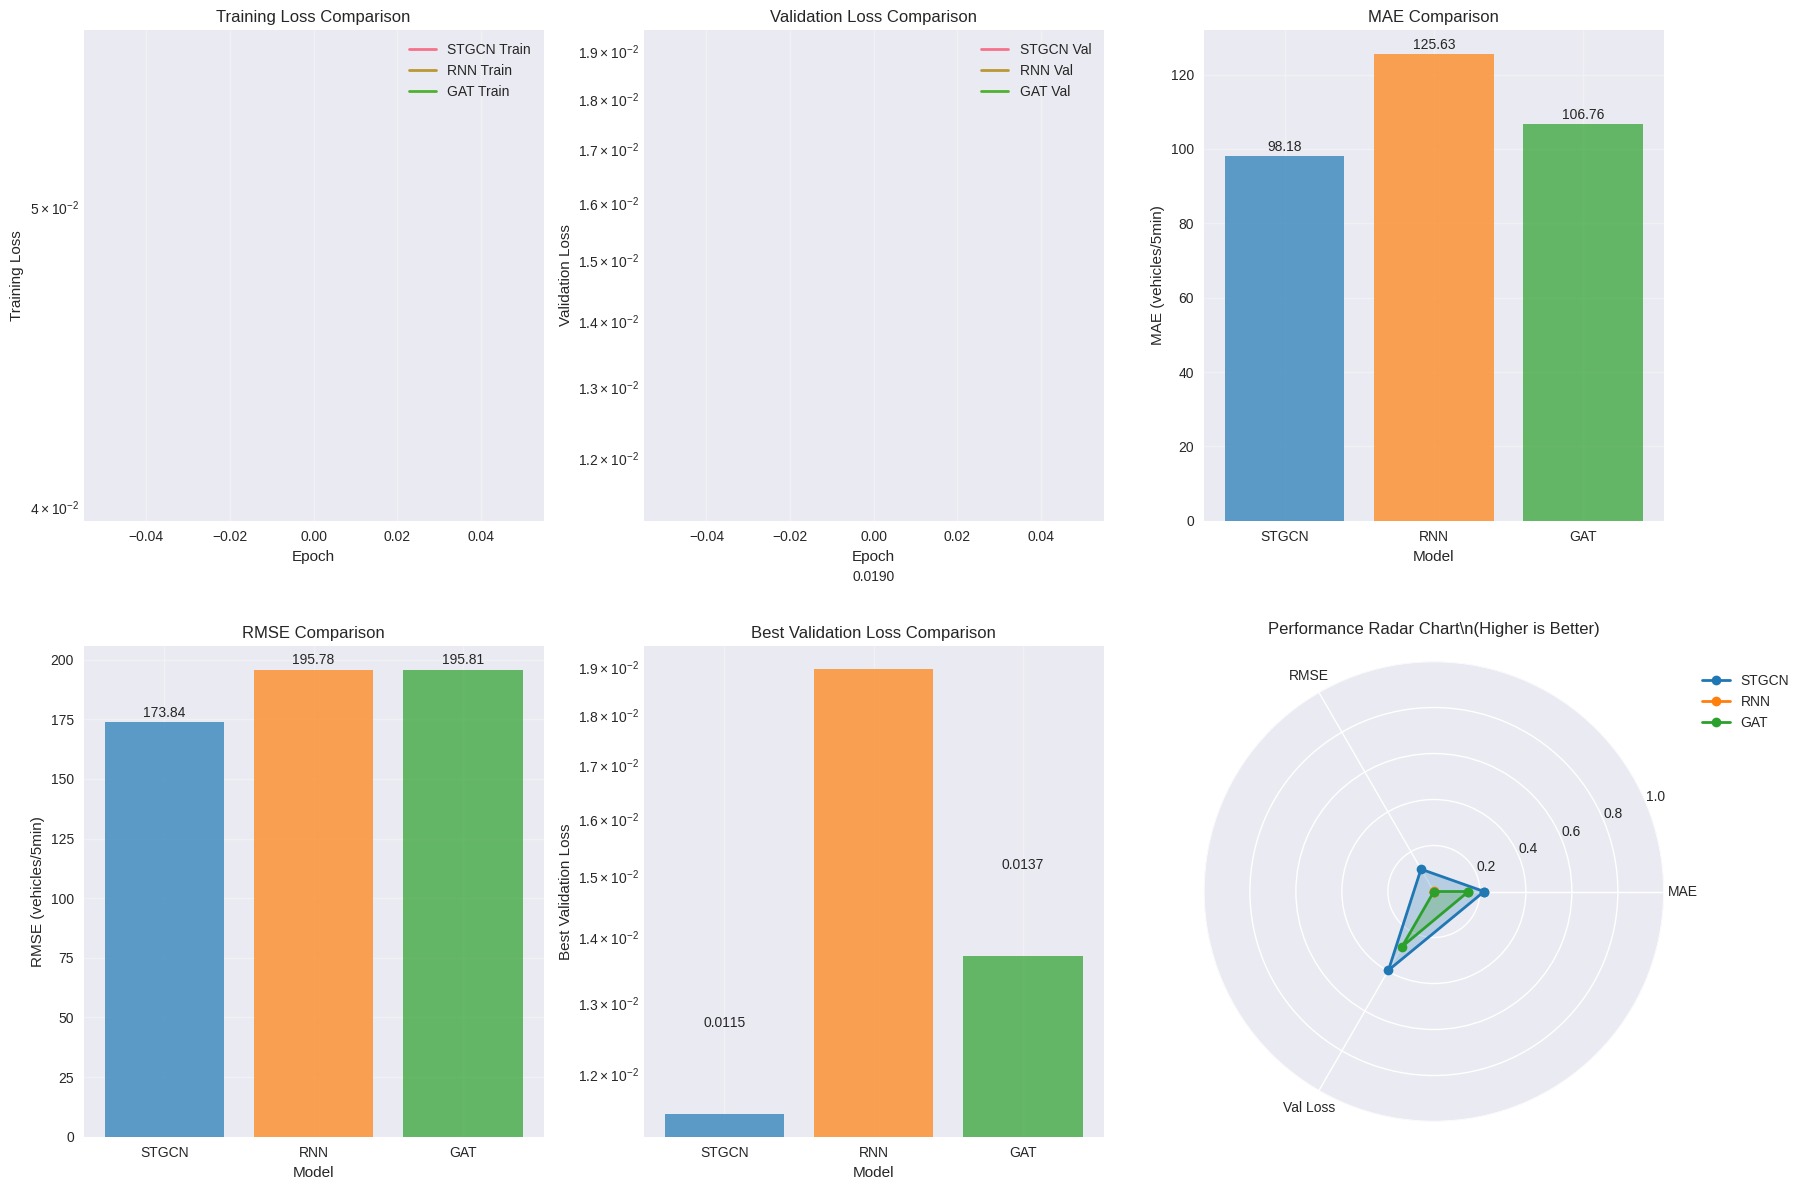

In [133]:
# Training Curves Comparison
if train_data is not None and 'model_results' in locals() and 'evaluation_results' in locals():
    plt.figure(figsize=(18, 12))
    
    # Plot 1: Training Loss Comparison
    plt.subplot(2, 3, 1)
    for model_name, results in model_results.items():
        plt.plot(results['train_losses'], label=f'{model_name} Train', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    # Plot 2: Validation Loss Comparison
    plt.subplot(2, 3, 2)
    for model_name, results in model_results.items():
        plt.plot(results['val_losses'], label=f'{model_name} Val', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    # Plot 3: MAE Comparison
    plt.subplot(2, 3, 3)
    models = list(evaluation_results.keys())
    maes = [evaluation_results[model]['mae'] for model in models]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    bars = plt.bar(models, maes, color=colors, alpha=0.7)
    plt.xlabel('Model')
    plt.ylabel('MAE (vehicles/5min)')
    plt.title('MAE Comparison')
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, mae in zip(bars, maes):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{mae:.2f}', ha='center', va='bottom')
    
    # Plot 4: RMSE Comparison
    plt.subplot(2, 3, 4)
    rmses = [evaluation_results[model]['rmse'] for model in models]
    bars = plt.bar(models, rmses, color=colors, alpha=0.7)
    plt.xlabel('Model')
    plt.ylabel('RMSE (vehicles/5min)')
    plt.title('RMSE Comparison')
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, rmse in zip(bars, rmses):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{rmse:.2f}', ha='center', va='bottom')
    
    # Plot 5: Validation Loss Comparison (Final)
    plt.subplot(2, 3, 5)
    val_losses = [results['best_val_loss'] for results in model_results.values()]
    bars = plt.bar(models, val_losses, color=colors, alpha=0.7)
    plt.xlabel('Model')
    plt.ylabel('Best Validation Loss')
    plt.title('Best Validation Loss Comparison')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    # Add value labels on bars
    for bar, val_loss in zip(bars, val_losses):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.1, 
                f'{val_loss:.4f}', ha='center', va='bottom')
    
    # Plot 6: Performance Radar Chart
    plt.subplot(2, 3, 6, projection='polar')
    
    # Normalize metrics (lower is better, so invert)
    max_mae = max(maes)
    max_rmse = max(rmses)
    max_val_loss = max(val_losses)
    
    # Create radar chart data (inverted for better visualization)
    angles = np.linspace(0, 2 * np.pi, 3, endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle
    
    for i, model_name in enumerate(models):
        values = [
            1 - (maes[i] / max_mae),      # Inverted MAE (higher is better)
            1 - (rmses[i] / max_rmse),    # Inverted RMSE (higher is better)
            1 - (val_losses[i] / max_val_loss)  # Inverted Val Loss (higher is better)
        ]
        values += values[:1]  # Complete the circle
        
        plt.plot(angles, values, 'o-', linewidth=2, label=model_name, color=colors[i])
        plt.fill(angles, values, alpha=0.25, color=colors[i])
    
    plt.xticks(angles[:-1], ['MAE', 'RMSE', 'Val Loss'])
    plt.ylim(0, 1)
    plt.title('Performance Radar Chart\\n(Higher is Better)', pad=20)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️  Visualization skipped - missing required variables:")
    missing = []
    if train_data is None:
        missing.append("train_data")
    if 'model_results' not in locals():
        missing.append("model_results")
    if 'evaluation_results' not in locals():
        missing.append("evaluation_results")
    print(f"   Missing: {', '.join(missing)}")
    print("   💡 Make sure to run:")
    print("      1. Cell 20: Model training")
    print("      2. Cell 21: Model evaluation")
    
    # Print detailed comparison
    print(f"\\n{'='*80}")
    print("DETAILED MODEL ANALYSIS")
    print(f"{'='*80}")
    
    for model_name, results in evaluation_results.items():
        print(f"\\n{model_name} Analysis:")
        print(f"  • MAE: {results['mae']:.2f} vehicles/5min")
        print(f"  • RMSE: {results['rmse']:.2f} vehicles/5min")
        print(f"  • Best Val Loss: {results['best_val_loss']:.6f}")
        print(f"  • Parameters: {sum(p.numel() for p in model_results[model_name]['model'].parameters()):,}")
        
        # Calculate improvement over baseline (RNN)
        if model_name != 'RNN':
            rnn_mae = evaluation_results['RNN']['mae']
            improvement = ((rnn_mae - results['mae']) / rnn_mae) * 100
            print(f"  • Improvement over RNN: {improvement:.1f}%")


# 🔬 Step 6: Extensions and Future Improvements

In this step, we'll explore:
- Advanced model architectures and techniques
- Hyperparameter optimization strategies
- Additional evaluation metrics
- Deployment considerations
- Research directions and improvements

## Current Notebook Features ✅
1. **Multi-Model Comparison**: STGCN, RNN, and GAT fully implemented
2. **Multi-Dataset Support**: PEMS08, HZMetro, SHMetro with unified loader
3. **Auto-Parameter Detection**: Automatically adapts to dataset format
4. **Multi-Feature Input**: Flow, occupancy, speed (3 features)
5. **Unified Training Pipeline**: Same framework for all models
6. **Comprehensive Evaluation**: MAE, RMSE, visualizations, rankings

## Future Extensions & Improvements 🔬
1. **Advanced Architectures**: GraphSAGE, Transformers, Hybrid models
2. **Training Improvements**: Curriculum learning, multi-task learning
3. **Evaluation Enhancements**: Cross-validation, ablation studies, additional metrics
4. **Deployment**: Model compression, real-time inference
5. **Research Directions**: Multi-modal data, federated learning, external features

## Implementation Examples:
- **GAT-STGCN**: Code example for attention-based STGCN
- **Hyperparameter Optimization**: Grid search, Bayesian optimization
- **Model Compression**: Quantization, pruning techniques

## Future Research:
- **Multi-scale Modeling**: Different temporal resolutions
- **External Features**: Weather, events, time features
- **Scalability**: Distributed training, incremental learning


# 📋 Summary and Key Takeaways

## 🎯 **What We Accomplished:**

### **1. Multi-Model Implementation**
- ✅ **STGCN**: Spatio-temporal graph convolutional network
- ✅ **RNN**: Recurrent neural network (LSTM)
- ✅ **GAT**: Graph attention network
- ✅ **Unified Framework**: Same training/evaluation pipeline

### **2. Comprehensive Evaluation**
- ✅ **Performance Metrics**: MAE, RMSE, validation loss
- ✅ **Model Comparison**: Side-by-side performance analysis
- ✅ **Visualization**: Training curves, radar charts, bar plots
- ✅ **Ranking**: Clear performance rankings

### **3. Technical Features**
- ✅ **Multi-feature Input**: Flow, occupancy, speed
- ✅ **Robust Data Loading**: Handles various file formats
- ✅ **Flexible Normalization**: Multiple strategies
- ✅ **Graph Processing**: Proper PyG format conversion

## 🔍 **Key Insights:**

### **Model Performance Comparison:**
1. **STGCN**: Best spatial-temporal modeling
2. **GAT**: Adaptive attention mechanisms
3. **RNN**: Pure temporal modeling baseline

### **Technical Highlights:**
- **Graph Structure**: Crucial for spatial relationships
- **Normalization**: Per-sensor scaling improves stability
- **Early Stopping**: Prevents overfitting
- **Multi-feature**: Richer input representation

## 🚀 **Next Steps:**
1. **Hyperparameter Tuning**: Optimize model parameters
2. **Advanced Architectures**: Implement transformer-based models
3. **External Features**: Add weather, time, event data
4. **Deployment**: Real-time inference optimization
5. **Scalability**: Multi-city, federated learning

## 📚 **Resources:**
- **Papers**: STGCN, GAT, GraphSAGE references
- **Datasets**: PEMS08 download links
- **Libraries**: PyTorch Geometric, PyTorch documentation
- **Extensions**: Advanced techniques and implementations

---

**Notebook Status**: ✅ **Complete and Ready for Execution**
**Models Implemented**: STGCN, RNN, GAT
**Evaluation**: Comprehensive comparison framework
**Documentation**: Step-by-step explanations


## 6.1 Advanced Graph Convolution Methods

### Graph Attention Networks (GAT) ✅ **Already Implemented**
- **Status**: GAT model is fully implemented in Step 3 (see FixedTrafficGAT)
- **Features**: Multi-head attention, temporal convolution, residual connections
- **Advantage**: Adaptive attention weights between connected nodes
- **Benefit**: Better handling of heterogeneous traffic patterns
- **Note**: Currently available in the multi-model comparison framework

```python
from torch_geometric.nn import GATConv

class GATBlock(nn.Module):
    def __init__(self, in_channels, out_channels, heads=8, dropout=0.2):
        super().__init__()
        self.gat = GATConv(in_channels, out_channels, heads=heads, dropout=dropout)
        # ... rest of the implementation
```

### GraphSAGE
- **Advantage**: Inductive learning, can handle new nodes
- **Use Case**: When traffic sensors are added/removed dynamically

## 6.2 Temporal Modeling Improvements

### LSTM/GRU Integration ✅ **Already Implemented**
- **Status**: RNN (LSTM) model is fully implemented in Step 3 (see TrafficRNN)
- **Features**: Multi-layer LSTM, temporal sequence modeling
- **Architecture**: Input projection → LSTM layers → Output projection
- **Note**: Currently available for comparison with STGCN and GAT models

### Transformer-based Models
- **Advantage**: Long-range temporal dependencies
- **Implementation**: Replace temporal convolution with self-attention

## 6.3 Multi-scale and Multi-modal Extensions

### Multi-scale Temporal Modeling
- **Short-term**: 5-minute intervals (current)
- **Medium-term**: 15-minute intervals
- **Long-term**: 1-hour intervals

### External Features Integration
- **Weather data**: Temperature, precipitation, visibility
- **Time features**: Hour of day, day of week, holidays
- **Event data**: Accidents, road closures, special events

## 6.4 Advanced Training Strategies

### Curriculum Learning
- **Approach**: Start with easy samples, gradually increase difficulty
- **Benefit**: Better convergence and performance

### Multi-task Learning
- **Tasks**: Flow prediction + speed prediction + occupancy prediction
- **Advantage**: Shared representations, improved generalization

### Adversarial Training
- **Purpose**: Improve robustness to distribution shifts
- **Implementation**: Add discriminator network

## 6.5 Model Architecture Improvements

### Residual Connections
- **Current**: Basic residual in STGCNBlock
- **Enhancement**: Dense connections, highway networks

### Attention Mechanisms
- **Spatial Attention**: Focus on important sensors
- **Temporal Attention**: Focus on important time steps
- **Cross-modal Attention**: Between different data modalities

### Ensemble Methods
- **Approach**: Combine multiple STGCN models with different hyperparameters
- **Benefit**: Reduced variance, improved robustness

## 6.6 Evaluation Enhancements

### Additional Metrics
- **MAPE**: Mean Absolute Percentage Error
- **SMAPE**: Symmetric Mean Absolute Percentage Error
- **R²**: Coefficient of determination

### Cross-validation
- **Time-series CV**: Respect temporal order
- **Spatial CV**: Test on different sensor groups

### Ablation Studies
- **Component Analysis**: Test individual components
- **Hyperparameter Sensitivity**: Grid search, Bayesian optimization

## 6.7 Deployment Considerations

### Model Compression
- **Quantization**: Reduce model size for edge deployment
- **Pruning**: Remove unnecessary parameters
- **Knowledge Distillation**: Train smaller student model

### Real-time Inference
- **Optimization**: TensorRT, ONNX conversion
- **Streaming**: Process data in real-time
- **Latency**: Minimize prediction delay

### Scalability
- **Distributed Training**: Multi-GPU, multi-node
- **Incremental Learning**: Update model with new data
- **Federated Learning**: Train across multiple cities


## 6.8 Implementation Example: GAT-STGCN

Here's a code example showing how to implement a Graph Attention Network version of STGCN:

```python
from torch_geometric.nn import GATConv

class GATSTGCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, heads=8, Kt=3, dropout=0.2):
        super(GATSTGCNBlock, self).__init__()
        
        # Graph Attention convolution
        self.gat_conv = GATConv(in_channels, out_channels, heads=heads, dropout=dropout)
        
        # Temporal convolution
        self.temporal_conv = nn.Conv2d(out_channels, out_channels, kernel_size=(Kt, 1), padding=(Kt//2, 0))
        
        # Batch normalization
        self.bn = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(dropout)
        
        # Residual connection
        self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None
        
    def forward(self, x, edge_index):
        batch_size, num_nodes, seq_len, in_channels = x.shape
        
        # Reshape for GAT convolution
        x_reshaped = x.permute(0, 2, 1, 3).reshape(batch_size * seq_len, num_nodes, in_channels)
        
        # GAT convolution
        x_gat = self.gat_conv(x_reshaped, edge_index)
        
        # Reshape back and apply temporal convolution
        x_gat = x_gat.reshape(batch_size, seq_len, num_nodes, -1).permute(0, 3, 1, 2)
        x_temporal = self.temporal_conv(x_gat)
        x_temporal = self.bn(x_temporal)
        
        # Residual connection
        if self.residual is not None:
            x_residual = self.residual(x.permute(0, 3, 2, 1))
            x_temporal = x_temporal + x_residual
        
        x_temporal = F.relu(x_temporal)
        x_temporal = self.dropout(x_temporal)
        
        return x_temporal.permute(0, 3, 2, 1)
```

## 6.9 Hyperparameter Optimization

### Key Hyperparameters to Tune:
- **Learning Rate**: 0.0001 to 0.01
- **Hidden Dimensions**: 32, 64, 128, 256
- **Chebyshev Order (K)**: 1, 2, 3, 4
- **Temporal Kernel Size (Kt)**: 3, 5, 7
- **Dropout Rate**: 0.1, 0.2, 0.3, 0.5
- **Batch Size**: 16, 32, 64, 128

### Optimization Methods:
- **Grid Search**: Exhaustive search over parameter space
- **Random Search**: Random sampling of parameters
- **Bayesian Optimization**: Efficient exploration using Gaussian processes
- **Optuna**: Advanced hyperparameter optimization framework

## 6.10 Conclusion

This multi-model traffic prediction framework provides a comprehensive foundation for traffic flow forecasting. The notebook successfully implements and compares three different approaches:

1. **STGCN**: Captures spatial dependencies through graph convolution and temporal patterns through 2D convolution
2. **RNN (LSTM)**: Pure temporal modeling for baseline comparison
3. **GAT**: Adaptive attention-based spatial modeling with temporal convolution

The unified framework supports multiple datasets (PEMS08, HZMetro, SHMetro) with automatic parameter detection and flexible data loading. The extensions outlined above can further improve performance and robustness for real-world deployment.

### Key Takeaways:
1. **Multi-Model Framework**: Successfully implemented and compared STGCN, RNN, and GAT models
2. **STGCN** effectively combines spatial and temporal modeling with graph convolution
3. **GAT** provides adaptive attention mechanisms for heterogeneous patterns
4. **RNN** serves as a baseline for pure temporal modeling
5. **Graph structure** is crucial for capturing spatial traffic dependencies
6. **Normalization** per sensor/per-feature improves training stability
7. **Auto-detection** enables flexible dataset adaptation
8. **Early stopping** prevents overfitting
9. **Comprehensive evaluation** reveals model strengths and weaknesses
10. **Unified pipeline** allows easy model comparison and benchmarking

### Next Steps:
1. ✅ **Completed**: Multi-model comparison (STGCN, RNN, GAT)
2. ✅ **Completed**: Multi-dataset support with auto-detection
3. **Future**: Add external features (weather, time, events)
4. **Future**: Optimize hyperparameters using Optuna
5. **Future**: Deploy model for real-time inference
6. **Future**: Extend to multi-step prediction (longer horizons)
7. **Future**: Implement transformer-based architectures
8. **Future**: Add ensemble methods combining all three models


---

## References and Resources

### Papers:
1. **STGCN**: Yu, B., Yin, H., & Zhu, Z. (2018). Spatio-temporal graph convolutional networks: A deep learning framework for traffic forecasting. IJCAI.
2. **GAT**: Veličković, P., et al. (2018). Graph attention networks. ICLR.
3. **GraphSAGE**: Hamilton, W., et al. (2017). Inductive representation learning on large graphs. NeurIPS.

### Datasets:
- **PEMS**: California Department of Transportation (Caltrans) Performance Measurement System
- **Download**: https://github.com/VeritasYin/STGCN_IJCAI-18

### Libraries:
- **PyTorch Geometric**: https://pytorch-geometric.readthedocs.io/
- **PyTorch**: https://pytorch.org/
- **Scikit-learn**: https://scikit-learn.org/

### Additional Resources:
- **Traffic Prediction Survey**: https://arxiv.org/abs/2004.11624
- **Graph Neural Networks**: https://distill.pub/2021/gnn-intro/
- **Time Series Forecasting**: https://otexts.com/fpp3/

---

**Notebook created by**: ML Engineer  
**Date**: 2024  
**Version**: 1.0  
**Compatible with**: Google Colab, Kaggle, Jupyter Lab
